In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import time
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from torchsummary import summary
from collections import deque

from di_dataset3 import DepthImageDataset, collate_batch

from torch.utils.tensorboard import SummaryWriter

2022-03-15 16:37:40.824720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/patricknit/.mujoco/mjpro150/bin
2022-03-15 16:37:40.824739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Hyperparams

In [3]:
LINUX = True

latent_dim = 64
num_epochs = 250
batch_size = 32
learning_rate = 1e-3

save_model = True
load_model = False

if LINUX:
    base_path = "/home/patricknit"
else:
    base_path = "/Users/patricknitschke/Library/CloudStorage/OneDrive-NTNU/NTNU/Kybernetikk og robotikk/Master/Thesis/Code"

tfrecord_folder = base_path + "/rl_data/tfrecord_wfiltered"
tfrecord_test_folder = tfrecord_folder + "/test"

save_model_file = base_path + "/vae_models/dronet_final_64_sum_old_weight"
load_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered_140.pth"

writer = SummaryWriter('runs'+save_model_file[save_model_file.rfind("/"):])

# Load Dataset

In [4]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # 180 tfrecords
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True) # 20 tfrecords

len_train_dataset, len_test_dataset = len(train_dataset), len(test_dataset)
n_training_samples = len_train_dataset * 32 # 32 samples per batch
print(len_train_dataset, len_test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

images, images_filtered, *_ = next(iter(train_loader)) # image, filtered image, height, width, depth
images.shape, images_filtered.shape

2022-03-15 16:37:42.416855: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-15 16:37:42.416892: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-03-15 16:37:42.417901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data98.tfrecords']
Iterating length... 	Done: 63
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data183.tfrecords']
Iterating length... 	Done: 70
63 70


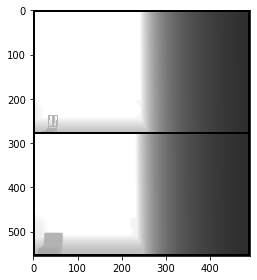

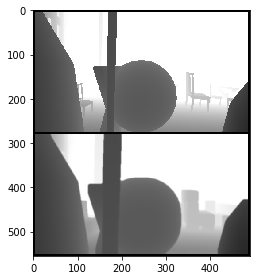

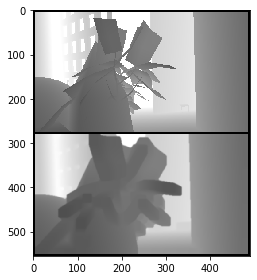

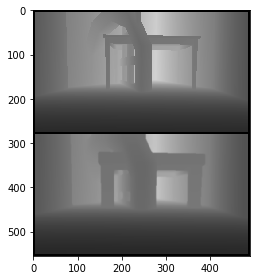

In [6]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

def make_grid_for_tensorboard(images_list, n_grids=2):
    joined_images = []
    [joined_images.extend(images[:n_grids]) for images in images_list]
    return torchvision.utils.make_grid(joined_images, nrow=1, padding=5)

def gridshow(images_list, n_grids=None):
    for n, items in enumerate(zip(*images_list)):
        grid = torchvision.utils.make_grid([*items], nrow=1, padding=5).permute(1, 2, 0)
        imshow(grid)
        if (n+1) == n_grids:
            return

gridshow([images, images_filtered], n_grids=4)
#imshow(make_grid_for_tensorboard([images, images_filtered]).permute(1,2,0))

# Define Variational Autoencoder

Adapted from https://github.com/microsoft/AirSim-Drone-Racing-VAE-Imitation/blob/master/racing_models/cmvae.py

### Dronet
ResNet8 as encoder.

In [15]:
class Dronet(nn.Module):
    def __init__(self, input_dim, num_outputs):
        super(Dronet, self).__init__()
        
        print('[Dronet] Starting dronet')

        self.bn0 = nn.BatchNorm2d(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.conv0 = nn.Conv2d(input_dim, 32, kernel_size=5, stride=2, padding=2)
        self.xavier_uniform_init(self.conv0)
        
        self.conv0_2 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)

        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv3)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 64, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv6)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(64, 128, kernel_size=1, stride=2)
        self.xavier_uniform_init(self.conv9)

        self.dense0 = nn.Linear(9*15*128, 64) # Todo: check size
        self.dense1 = nn.Linear(64, num_outputs)

        print('[Dronet] Done with dronet')
    
    
    def xavier_uniform_init(self, m):
        """
        Default initialisation in Keras is glorot_uniform == xavier_uniform in Pytorch

        https://discuss.pytorch.org/t/crossentropyloss-expected-object-of-type-torch-longtensor/28683/6?u=ptrblck
        https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('linear')) # gain=nn.init.calculate_gain('relu')
            nn.init.zeros_(m.bias)
        return m

    def forward(self, img):
        # Input
        
        x1 = self.conv0(img)
        #x1, indices = self.max0(x1)
        x1 = self.conv0_2(x1)

        # First residual block
        x2 = self.bn0(x1)
        x2 = torch.relu(x2)
        x2 = self.conv1(x2)

        x2 = self.bn1(x2)
        x2 = torch.relu(x2)
        x2 = self.conv2(x2)
        
        x1 = self.conv3(x1)
        x3 = x1+x2

        # Second residual block
        x4 = self.bn2(x3)
        # x4 = x3
        x4 = torch.relu(x4)
        x4 = self.conv4(x4)

        x4 = self.bn3(x4)
        x4 = torch.relu(x4)
        x4 = self.conv5(x4)
        
        x3 = self.conv6(x3)
        x5 = x3+x4 # 34, 60, 64

        # Third residual block
        x6 = self.bn4(x5)
        x6 = torch.relu(x6)
        x6 = self.conv7(x6)

        x6 = self.bn5(x6)
        x6 = torch.relu(x6)
        x6 = self.conv8(x6)

        x5 = self.conv9(x5)
        x7 = x5+x6 # 17, 30, 128
        
        x = x7.view(x7.size(0), 9*15*128)

        x = torch.relu(x)
        x = self.dense0(x)
        x = torch.relu(x)        
        x_enc = self.dense1(x)
        return x_enc

dronet = Dronet(input_dim=1, num_outputs=latent_dim*2)
summary(dronet, input_size=(1, 270, 480), batch_size=-1, device=device.type)

class ImgDecoder(nn.Module):
    def __init__(self, input_dim=100, batch=32):
        super(ImgDecoder, self).__init__()
        print('[ImgDecoder] Starting create_model')
        self.dense = nn.Linear(input_dim, 9*15*128)
        
        self.bn0 = nn.BatchNorm2d(128)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(16)
        
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0), dilation=1)
        self.deconv5 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=(2,2), output_padding=(0,1), dilation=1)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=(2,2), output_padding=(0,0))
        self.deconv7 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=1, padding=2) # tanh activation or sigmoid

        print('[ImgDecoder] Done with create_model')

    def forward(self, z):
        x = self.dense(z)
        x = x.view(x.size(0), 128, 9, 15)
        
        x = self.deconv1(x)
#         x = self.bn1(x)
        x = torch.relu(x)
        
        x = self.deconv2(x)
#         x = self.bn2(x)
        x = torch.relu(x)
        
        x = self.deconv3(x)
#         x = self.bn3(x)
        x = torch.relu(x)

        x = self.deconv4(x)
#         x = self.bn4(x)
        x = torch.relu(x)

        x = self.deconv5(x)
#         x = self.bn5(x)
        #x = self.unpool(x, indices, output_size=(x.size(0), 1, 135, 240))
        x = torch.relu(x)
        
        x = self.deconv6(x)
#         x = self.bn6(x)
        x = torch.relu(x)

        x = self.deconv7(x)
        x = torch.sigmoid(x)
        return x

img_decoder = ImgDecoder(input_dim=latent_dim, batch=1)
summary(img_decoder, (1,latent_dim))

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
        

class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        
        # create the 3 base models:
        self.q_img = Dronet(input_dim=1, num_outputs=n_z*2)
        self.p_img = ImgDecoder(input_dim=n_z)
        
        # Create sampler
        self.mean_params = Lambda(lambda x: x[:, :n_z])
        self.logvar_params = Lambda(lambda x: x[:, n_z:])

    def forward(self, x):

        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)
        z = means + eps * stddev

        img_recon = self.p_img(z)
        
        return img_recon, means, logvar, z
    
    def forward_test(self, x):
        x = self.q_img(x)
        
        means = self.mean_params(x)
        logvar = self.logvar_params(x)
        stddev = torch.exp(0.5 * logvar)
        eps = torch.zeros_like(stddev)
        z = means + eps * stddev

        img_recon = self.p_img(z)
        return img_recon, means, logvar, z
        

    def encode(self, x):
        x = self.q_img(x)
        means = self.mean_params(x)
        stddev = torch.exp(0.5 * self.stddev_params(x))
        eps = torch.randn_like(stddev)
        z = means + eps * stddev
        return z, means, stddev

    def decode(self, z, mode):
        img_recon = self.p_img(z)
        return img_recon


[Dronet] Starting dronet
[Dronet] Done with dronet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 30]           2,112
      BatchNorm2d-13           [-1, 64, 17, 30]     

### Define Model

In [10]:
vae_model = VAE(n_z=latent_dim).to(device)
writer.add_graph(vae_model, images)

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))
    print(f"Loaded model: {load_model_file}")

optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
summary(vae_model, (1, 270, 480))

[Dronet] Starting dronet
[Dronet] Done with dronet
[ImgDecoder] Starting create_model
[ImgDecoder] Done with create_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 135, 240]             832
            Conv2d-2          [-1, 32, 68, 120]          25,632
       BatchNorm2d-3          [-1, 32, 68, 120]              64
            Conv2d-4           [-1, 32, 34, 60]           9,248
       BatchNorm2d-5           [-1, 32, 34, 60]              64
            Conv2d-6           [-1, 32, 34, 60]           9,248
            Conv2d-7           [-1, 32, 34, 60]           1,056
       BatchNorm2d-8           [-1, 32, 34, 60]              64
            Conv2d-9           [-1, 64, 17, 30]          18,496
      BatchNorm2d-10           [-1, 64, 17, 30]             128
           Conv2d-11           [-1, 64, 17, 30]          36,928
           Conv2d-12           [-1, 64, 17, 3

/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/jit/_trace.py:983: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 64, strides=[64, 1], requires_grad=0, device=cpu) = aten::randn_like(%stddev, %523, %524, %525, %526, %527) # /tmp/ipykernel_4005355/3683525493.py:29:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/jit/_trace.py:983: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 3477465 / 4147200 (83.9%)
Greatest absolute difference: 0.000496983528137207 at index (12, 0, 118, 109) (up to 1e-05 allowed)
Greatest relative difference: 0.0008973677356585827 at index (12, 0, 118, 109) (up to 1e-05 allowed)
  _check_tr

# Training

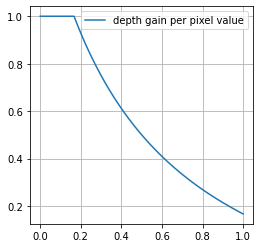

In [11]:
def depth_gain(x):
    return np.minimum(1/(x + 0.5) - 0.5, 1*np.ones_like(x))

x = np.arange(0, 1.001, 0.001)
y = depth_gain(x)

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.grid()
plt.legend(["depth gain per pixel value"])
plt.show()

In [12]:
def BCELoss(x, x_hat, mean, log_var):
    reproduction_loss = nn.BCELoss(reduction='mean')(x_hat, x) * (270 * 480)
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

def MSE(x, x_hat, mu, logvar):
    reproduction_loss = F.mse_loss(x_hat, x, reduction="mean") * (270 * 480)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss - kl_divergence

def weighted_MSE(x, x_hat, mu, logvar):
    reproduction_loss = (depth_gain(x) * torch.square(x_hat - x)).sum() # Old version, reduce by mean later
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

def filtered_weighted_MSE(filtered_x, x_hat, mu, logvar): 
    reproduction_loss = (depth_gain(filtered_x) * torch.square(x_hat - filtered_x)).sum() # change later to mean
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss - kl_divergence

In [13]:
time_iteration = deque(maxlen=100)
total_train_iterations = 0
total_test_iterations = 0

if load_model:
    start = load_model_file.rfind("_") + 1
    end = load_model_file.rfind(".")
    epoch_start = int("".join([char for char in load_model_file[start:end]]))
    num_epochs = [epoch_start, num_epochs]
else:
    num_epochs = [num_epochs]
    
for epoch in range(*num_epochs):
    # Random file each time
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    train_iterations = len(train_loader)

    test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size, one_tfrecord=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)
    test_iterations = len(test_loader)
    
    print("Training...")
    vae_model.train()
    running_loss = 0.0
    since = time.time()
    for i, (image, image_filtered, *_) in enumerate(train_loader):
        since_iter = time.time() 
        optimiser.zero_grad()
        
        image = image.to(device)
        image_filtered = image_filtered.to(device)

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = filtered_weighted_MSE(image_filtered, x_hat, mu, logvar)
        running_loss += loss.item()

        # Update weights
        loss.backward()
        optimiser.step()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
    
        # Log info
        writer.add_scalar('training/loss', running_loss/((i+1)*batch_size), global_step=total_train_iterations)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{train_iterations}, Avg. train loss:", \
                  f"{running_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter", \
                  f"{iter_time_mean:.2f}, Est. time left {iter_time_mean*(train_iterations - (i+1)):.2f}")
        if (i+1) % (5) == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('training/images', grid, global_step=total_train_iterations)
            
        total_train_iterations += 1
    
    print("Testing...")
    vae_model.eval()
    test_loss = 0.0
    since = time.time()
    for i, (image, image_filtered, *_) in enumerate(test_loader):
        since_iter = time.time() 
        optimiser.zero_grad()
        
        image = image.to(device)
        image_filtered = image_filtered.to(device)

        # VAE forward pass
        x_hat, mu, logvar, z = vae_model(image)

        # Loss
        loss = filtered_weighted_MSE(image_filtered, x_hat, mu, logvar)
        test_loss += loss.item()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
    
        # Log info
        writer.add_scalar('test/loss', test_loss/((i+1)*batch_size), global_step=total_test_iterations)
        if (i+1) % (5) == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs[-1]}, Step: {i+1}/{test_iterations}, Avg. test loss:", \
                  f"{test_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter", \
                  f"{iter_time_mean:.2f}, Est. time left {iter_time_mean*(test_iterations - (i+1)):.2f}")
            
        if (i+1) % (5) == 0:
            grid = make_grid_for_tensorboard([image, image_filtered, x_hat], n_grids=1)
            writer.add_image('test/images', grid, global_step=total_test_iterations)
            
        total_test_iterations += 1
    
    print(f"Epoch: {epoch+1}, Training loss: {running_loss/(train_iterations*batch_size):.3f}, Test loss: {test_loss/(test_iterations*batch_size):.3f}")
    writer.add_scalar('loss_per_epoch/train', running_loss/(train_iterations*batch_size), global_step=epoch)
    writer.add_scalar('loss_per_epoch/test', test_loss/(test_iterations*batch_size), global_step=epoch)

    
    # Save every 10 epochs
    if (epoch+1) % 10 == 0:
        save_model_file_dir = save_model_file + f"_{epoch+1}.pth"
        torch.save(vae_model.state_dict(), save_model_file_dir)
            

Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data18.tfrecords']
Iterating length... 	Done: 66
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data180.tfrecords']
Iterating length... 	Done: 64
Training...
gotcha
Epoch: 1/250, Step: 5/66, Avg. train loss: 10235.510, time: 22.22, Avg. per iter 4.38, Est. time left 267.03
Epoch: 1/250, Step: 10/66, Avg. train loss: 8630.730, time: 45.18, Avg. per iter 4.48, Est. time left 250.65
Epoch: 1/250, Step: 15/66, Avg. train loss: 7372.062, time: 68.58, Avg. per iter 4.54, Est. time left 231.43
Epoch: 1/250, Step: 20/66, Avg. train loss: 6582.264, time: 91.36, Avg. per iter 4.54, Est. time left 208.74
Epoch: 1/250, Step: 25/66, Avg. train loss: 5958.883, time: 114.16, Avg. per iter 4.54, Est. time left 186.08
Epoch: 1/250, Step: 30/66, Avg. train loss: 5593.362, time: 135.08, Avg. per iter 4.48, Est. time left 161.15
Epoch: 1/250, Step: 35/66, Avg. train loss: 5388.762, time: 156.83, Avg. per iter 4.4

Epoch: 3/250, Step: 10/64, Avg. test loss: 2017.611, time: 19.04, Avg. per iter 3.46, Est. time left 186.78
Epoch: 3/250, Step: 15/64, Avg. test loss: 2088.867, time: 28.20, Avg. per iter 3.47, Est. time left 170.26
Epoch: 3/250, Step: 20/64, Avg. test loss: 2113.559, time: 36.45, Avg. per iter 3.48, Est. time left 153.21
Epoch: 3/250, Step: 25/64, Avg. test loss: 2114.591, time: 44.91, Avg. per iter 3.49, Est. time left 135.98
Epoch: 3/250, Step: 30/64, Avg. test loss: 2141.664, time: 53.13, Avg. per iter 3.48, Est. time left 118.21
Epoch: 3/250, Step: 35/64, Avg. test loss: 2132.550, time: 61.17, Avg. per iter 3.45, Est. time left 100.01
Epoch: 3/250, Step: 40/64, Avg. test loss: 2174.615, time: 69.31, Avg. per iter 3.30, Est. time left 79.22
Epoch: 3/250, Step: 45/64, Avg. test loss: 2152.698, time: 77.32, Avg. per iter 3.17, Est. time left 60.16
Epoch: 3/250, Step: 50/64, Avg. test loss: 2153.746, time: 85.31, Avg. per iter 3.02, Est. time left 42.28
Epoch: 3/250, Step: 55/64, Avg.

Epoch: 6/250, Step: 35/69, Avg. train loss: 1415.015, time: 148.05, Avg. per iter 2.71, Est. time left 92.19
Epoch: 6/250, Step: 40/69, Avg. train loss: 1399.660, time: 168.37, Avg. per iter 2.69, Est. time left 78.14
Epoch: 6/250, Step: 45/69, Avg. train loss: 1428.802, time: 188.83, Avg. per iter 2.75, Est. time left 65.98
Epoch: 6/250, Step: 50/69, Avg. train loss: 1476.773, time: 209.92, Avg. per iter 2.88, Est. time left 54.67
Epoch: 6/250, Step: 55/69, Avg. train loss: 1489.129, time: 230.60, Avg. per iter 3.00, Est. time left 42.03
Epoch: 6/250, Step: 60/69, Avg. train loss: 1493.908, time: 250.70, Avg. per iter 3.12, Est. time left 28.10
Epoch: 6/250, Step: 65/69, Avg. train loss: 1497.233, time: 270.90, Avg. per iter 3.24, Est. time left 12.97
Testing...
gotcha
Epoch: 6/250, Step: 5/71, Avg. test loss: 1528.110, time: 8.58, Avg. per iter 3.31, Est. time left 218.60
Epoch: 6/250, Step: 10/71, Avg. test loss: 1534.227, time: 16.39, Avg. per iter 3.31, Est. time left 201.94
Epoch

Epoch: 11/250, Step: 10/64, Avg. test loss: 1422.736, time: 17.79, Avg. per iter 3.86, Est. time left 208.43
Epoch: 11/250, Step: 15/64, Avg. test loss: 1376.921, time: 26.45, Avg. per iter 3.86, Est. time left 189.01
Epoch: 11/250, Step: 20/64, Avg. test loss: 1368.346, time: 34.70, Avg. per iter 3.85, Est. time left 169.39
Epoch: 11/250, Step: 25/64, Avg. test loss: 1364.828, time: 43.21, Avg. per iter 3.85, Est. time left 150.10
Epoch: 11/250, Step: 30/64, Avg. test loss: 1344.357, time: 51.68, Avg. per iter 3.71, Est. time left 126.29
Epoch: 11/250, Step: 35/64, Avg. test loss: 1319.099, time: 60.21, Avg. per iter 3.56, Est. time left 103.26
Epoch: 11/250, Step: 40/64, Avg. test loss: 1323.732, time: 68.45, Avg. per iter 3.40, Est. time left 81.59
Epoch: 11/250, Step: 45/64, Avg. test loss: 1326.429, time: 76.65, Avg. per iter 3.23, Est. time left 61.43
Epoch: 11/250, Step: 50/64, Avg. test loss: 1324.686, time: 84.87, Avg. per iter 3.08, Est. time left 43.07
Epoch: 11/250, Step: 5

Epoch: 14/250, Step: 35/63, Avg. train loss: 1263.666, time: 149.96, Avg. per iter 2.53, Est. time left 70.90
Epoch: 14/250, Step: 40/63, Avg. train loss: 1255.757, time: 170.41, Avg. per iter 2.66, Est. time left 61.12
Epoch: 14/250, Step: 45/63, Avg. train loss: 1261.243, time: 190.69, Avg. per iter 2.78, Est. time left 50.09
Epoch: 14/250, Step: 50/63, Avg. train loss: 1261.706, time: 211.15, Avg. per iter 2.90, Est. time left 37.71
Epoch: 14/250, Step: 55/63, Avg. train loss: 1255.492, time: 231.96, Avg. per iter 3.03, Est. time left 24.22
Epoch: 14/250, Step: 60/63, Avg. train loss: 1243.489, time: 252.74, Avg. per iter 3.15, Est. time left 9.45
Testing...
gotcha
Epoch: 14/250, Step: 5/64, Avg. test loss: 1137.942, time: 8.48, Avg. per iter 3.20, Est. time left 189.00
Epoch: 14/250, Step: 10/64, Avg. test loss: 1180.823, time: 16.94, Avg. per iter 3.21, Est. time left 173.36
Epoch: 14/250, Step: 15/64, Avg. test loss: 1164.066, time: 24.88, Avg. per iter 3.21, Est. time left 157.4

Epoch: 16/250, Step: 60/66, Avg. test loss: 1234.044, time: 93.46, Avg. per iter 2.70, Est. time left 16.21
Epoch: 16/250, Step: 65/66, Avg. test loss: 1237.070, time: 101.01, Avg. per iter 2.56, Est. time left 2.56
Epoch: 16, Training loss: 1065.390, Test loss: 1234.608
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data121.tfrecords']
Iterating length... 	Done: 60
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data189.tfrecords']
Iterating length... 	Done: 56
Training...
gotcha
Epoch: 17/250, Step: 5/60, Avg. train loss: 1145.908, time: 23.92, Avg. per iter 2.54, Est. time left 139.58
Epoch: 17/250, Step: 10/60, Avg. train loss: 1208.716, time: 48.15, Avg. per iter 2.54, Est. time left 127.17
Epoch: 17/250, Step: 15/60, Avg. train loss: 1228.454, time: 71.39, Avg. per iter 2.54, Est. time left 114.36
Epoch: 17/250, Step: 20/60, Avg. train loss: 1254.226, time: 92.60, Avg. per iter 2.52, Est. time left 100.80
Epoch: 17/250, Step: 25/60, A

Epoch: 19/250, Step: 10/70, Avg. test loss: 1228.599, time: 17.49, Avg. per iter 3.52, Est. time left 211.36
Epoch: 19/250, Step: 15/70, Avg. test loss: 1222.948, time: 25.82, Avg. per iter 3.52, Est. time left 193.50
Epoch: 19/250, Step: 20/70, Avg. test loss: 1253.050, time: 34.12, Avg. per iter 3.51, Est. time left 175.64
Epoch: 19/250, Step: 25/70, Avg. test loss: 1231.711, time: 42.64, Avg. per iter 3.51, Est. time left 157.95
Epoch: 19/250, Step: 30/70, Avg. test loss: 1217.962, time: 51.03, Avg. per iter 3.52, Est. time left 140.66
Epoch: 19/250, Step: 35/70, Avg. test loss: 1206.216, time: 59.06, Avg. per iter 3.50, Est. time left 122.44
Epoch: 19/250, Step: 40/70, Avg. test loss: 1194.403, time: 67.11, Avg. per iter 3.36, Est. time left 100.85
Epoch: 19/250, Step: 45/70, Avg. test loss: 1188.234, time: 75.40, Avg. per iter 3.21, Est. time left 80.21
Epoch: 19/250, Step: 50/70, Avg. test loss: 1173.190, time: 83.79, Avg. per iter 3.04, Est. time left 60.74
Epoch: 19/250, Step: 

Iterating length... 	Done: 64
Training...
gotcha
Epoch: 22/250, Step: 5/61, Avg. train loss: 1143.275, time: 22.73, Avg. per iter 2.52, Est. time left 141.11
Epoch: 22/250, Step: 10/61, Avg. train loss: 1119.774, time: 45.75, Avg. per iter 2.54, Est. time left 129.41
Epoch: 22/250, Step: 15/61, Avg. train loss: 1110.207, time: 68.00, Avg. per iter 2.55, Est. time left 117.47
Epoch: 22/250, Step: 20/61, Avg. train loss: 1090.177, time: 89.53, Avg. per iter 2.57, Est. time left 105.17
Epoch: 22/250, Step: 25/61, Avg. train loss: 1108.962, time: 111.20, Avg. per iter 2.57, Est. time left 92.68
Epoch: 22/250, Step: 30/61, Avg. train loss: 1115.362, time: 132.76, Avg. per iter 2.58, Est. time left 80.01
Epoch: 22/250, Step: 35/61, Avg. train loss: 1123.821, time: 154.32, Avg. per iter 2.58, Est. time left 67.17
Epoch: 22/250, Step: 40/61, Avg. train loss: 1109.803, time: 175.99, Avg. per iter 2.72, Est. time left 57.05
Epoch: 22/250, Step: 45/61, Avg. train loss: 1112.967, time: 197.84, Avg

Epoch: 24/250, Step: 60/61, Avg. test loss: 1493.044, time: 96.81, Avg. per iter 2.68, Est. time left 2.68
Epoch: 24, Training loss: 1169.706, Test loss: 1494.041
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data98.tfrecords']
Iterating length... 	Done: 63
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data185.tfrecords']
Iterating length... 	Done: 66
Training...
gotcha
Epoch: 25/250, Step: 5/63, Avg. train loss: 1060.861, time: 22.44, Avg. per iter 2.65, Est. time left 153.68
Epoch: 25/250, Step: 10/63, Avg. train loss: 1117.692, time: 43.82, Avg. per iter 2.64, Est. time left 139.97
Epoch: 25/250, Step: 15/63, Avg. train loss: 1112.161, time: 65.27, Avg. per iter 2.63, Est. time left 126.42
Epoch: 25/250, Step: 20/63, Avg. train loss: 1088.473, time: 86.84, Avg. per iter 2.63, Est. time left 113.15
Epoch: 25/250, Step: 25/63, Avg. train loss: 1063.727, time: 107.84, Avg. per iter 2.62, Est. time left 99.40
Epoch: 25/250, Step: 30/63, A

Epoch: 27/250, Step: 25/71, Avg. test loss: 1320.049, time: 45.32, Avg. per iter 3.44, Est. time left 158.03
Epoch: 27/250, Step: 30/71, Avg. test loss: 1329.602, time: 54.60, Avg. per iter 3.44, Est. time left 141.05
Epoch: 27/250, Step: 35/71, Avg. test loss: 1330.542, time: 63.23, Avg. per iter 3.44, Est. time left 123.73
Epoch: 27/250, Step: 40/71, Avg. test loss: 1339.598, time: 71.89, Avg. per iter 3.43, Est. time left 106.40
Epoch: 27/250, Step: 45/71, Avg. test loss: 1341.463, time: 80.62, Avg. per iter 3.33, Est. time left 86.57
Epoch: 27/250, Step: 50/71, Avg. test loss: 1333.459, time: 89.44, Avg. per iter 3.18, Est. time left 66.87
Epoch: 27/250, Step: 55/71, Avg. test loss: 1339.717, time: 98.25, Avg. per iter 3.04, Est. time left 48.69
Epoch: 27/250, Step: 60/71, Avg. test loss: 1330.621, time: 106.98, Avg. per iter 2.89, Est. time left 31.82
Epoch: 27/250, Step: 65/71, Avg. test loss: 1325.888, time: 115.61, Avg. per iter 2.73, Est. time left 16.38
Epoch: 27/250, Step: 7

Epoch: 30/250, Step: 50/60, Avg. train loss: 1263.475, time: 218.99, Avg. per iter 2.98, Est. time left 29.83
Epoch: 30/250, Step: 55/60, Avg. train loss: 1242.047, time: 240.01, Avg. per iter 3.11, Est. time left 15.54
Epoch: 30/250, Step: 60/60, Avg. train loss: 1218.723, time: 257.43, Avg. per iter 3.19, Est. time left 0.00
Testing...
gotcha
Epoch: 30/250, Step: 5/66, Avg. test loss: 1422.916, time: 8.50, Avg. per iter 3.19, Est. time left 194.64
Epoch: 30/250, Step: 10/66, Avg. test loss: 1302.535, time: 16.67, Avg. per iter 3.19, Est. time left 178.69
Epoch: 30/250, Step: 15/66, Avg. test loss: 1321.092, time: 24.82, Avg. per iter 3.19, Est. time left 162.89
Epoch: 30/250, Step: 20/66, Avg. test loss: 1296.729, time: 32.69, Avg. per iter 3.19, Est. time left 146.88
Epoch: 30/250, Step: 25/66, Avg. test loss: 1260.123, time: 40.85, Avg. per iter 3.20, Est. time left 131.09
Epoch: 30/250, Step: 30/66, Avg. test loss: 1251.028, time: 48.83, Avg. per iter 3.20, Est. time left 115.11
E

Epoch: 33/250, Step: 15/68, Avg. train loss: 1109.760, time: 63.96, Avg. per iter 2.51, Est. time left 133.20
Epoch: 33/250, Step: 20/68, Avg. train loss: 1093.896, time: 85.21, Avg. per iter 2.51, Est. time left 120.55
Epoch: 33/250, Step: 25/68, Avg. train loss: 1086.414, time: 106.71, Avg. per iter 2.51, Est. time left 107.95
Epoch: 33/250, Step: 30/68, Avg. train loss: 1100.430, time: 127.95, Avg. per iter 2.51, Est. time left 95.31
Epoch: 33/250, Step: 35/68, Avg. train loss: 1091.079, time: 149.17, Avg. per iter 2.54, Est. time left 83.81
Epoch: 33/250, Step: 40/68, Avg. train loss: 1072.005, time: 170.41, Avg. per iter 2.66, Est. time left 74.47
Epoch: 33/250, Step: 45/68, Avg. train loss: 1085.243, time: 191.47, Avg. per iter 2.78, Est. time left 63.91
Epoch: 33/250, Step: 50/68, Avg. train loss: 1098.113, time: 214.91, Avg. per iter 2.93, Est. time left 52.74
Epoch: 33/250, Step: 55/68, Avg. train loss: 1099.571, time: 238.88, Avg. per iter 3.08, Est. time left 40.06
Epoch: 33

Epoch: 35/250, Step: 35/66, Avg. test loss: 1037.289, time: 60.18, Avg. per iter 3.51, Est. time left 108.71
Epoch: 35/250, Step: 40/66, Avg. test loss: 1055.778, time: 69.36, Avg. per iter 3.46, Est. time left 89.89
Epoch: 35/250, Step: 45/66, Avg. test loss: 1048.242, time: 78.11, Avg. per iter 3.30, Est. time left 69.25
Epoch: 35/250, Step: 50/66, Avg. test loss: 1037.609, time: 86.35, Avg. per iter 3.11, Est. time left 49.73
Epoch: 35/250, Step: 55/66, Avg. test loss: 1033.573, time: 94.36, Avg. per iter 2.92, Est. time left 32.13
Epoch: 35/250, Step: 60/66, Avg. test loss: 1041.138, time: 102.41, Avg. per iter 2.75, Est. time left 16.52
Epoch: 35/250, Step: 65/66, Avg. test loss: 1042.277, time: 110.39, Avg. per iter 2.58, Est. time left 2.58
Epoch: 35, Training loss: 1208.290, Test loss: 1032.176
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data150.tfrecords']
Iterating length... 	Done: 74
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/

Epoch: 38/250, Step: 40/62, Avg. train loss: 992.701, time: 174.03, Avg. per iter 2.71, Est. time left 59.63
Epoch: 38/250, Step: 45/62, Avg. train loss: 998.037, time: 195.36, Avg. per iter 2.84, Est. time left 48.29
Epoch: 38/250, Step: 50/62, Avg. train loss: 986.303, time: 216.71, Avg. per iter 2.96, Est. time left 35.49
Epoch: 38/250, Step: 55/62, Avg. train loss: 987.228, time: 237.79, Avg. per iter 3.08, Est. time left 21.55
Epoch: 38/250, Step: 60/62, Avg. train loss: 987.640, time: 259.31, Avg. per iter 3.21, Est. time left 6.42
Testing...
gotcha
Epoch: 38/250, Step: 5/66, Avg. test loss: 1070.220, time: 8.65, Avg. per iter 3.26, Est. time left 198.73
Epoch: 38/250, Step: 10/66, Avg. test loss: 1094.826, time: 17.38, Avg. per iter 3.27, Est. time left 183.04
Epoch: 38/250, Step: 15/66, Avg. test loss: 1082.514, time: 26.10, Avg. per iter 3.28, Est. time left 167.16
Epoch: 38/250, Step: 20/66, Avg. test loss: 1093.839, time: 34.55, Avg. per iter 3.28, Est. time left 150.85
Epoc

Epoch: 41/250, Step: 10/56, Avg. train loss: 1054.013, time: 40.14, Avg. per iter 2.25, Est. time left 103.73
Epoch: 41/250, Step: 15/56, Avg. train loss: 1044.345, time: 60.22, Avg. per iter 2.26, Est. time left 92.80
Epoch: 41/250, Step: 20/56, Avg. train loss: 1057.580, time: 79.90, Avg. per iter 2.27, Est. time left 81.60
Epoch: 41/250, Step: 25/56, Avg. train loss: 1084.413, time: 99.66, Avg. per iter 2.27, Est. time left 70.42
Epoch: 41/250, Step: 30/56, Avg. train loss: 1090.656, time: 119.15, Avg. per iter 2.27, Est. time left 59.06
Epoch: 41/250, Step: 35/56, Avg. train loss: 1082.929, time: 138.63, Avg. per iter 2.33, Est. time left 48.96
Epoch: 41/250, Step: 40/56, Avg. train loss: 1067.258, time: 158.14, Avg. per iter 2.45, Est. time left 39.19
Epoch: 41/250, Step: 45/56, Avg. train loss: 1070.541, time: 177.39, Avg. per iter 2.56, Est. time left 28.20
Epoch: 41/250, Step: 50/56, Avg. train loss: 1070.524, time: 196.74, Avg. per iter 2.68, Est. time left 16.08
Epoch: 41/250

Epoch: 43/250, Step: 40/71, Avg. test loss: 1205.997, time: 61.38, Avg. per iter 2.92, Est. time left 90.39
Epoch: 43/250, Step: 45/71, Avg. test loss: 1214.948, time: 68.96, Avg. per iter 2.80, Est. time left 72.74
Epoch: 43/250, Step: 50/71, Avg. test loss: 1210.832, time: 76.59, Avg. per iter 2.68, Est. time left 56.27
Epoch: 43/250, Step: 55/71, Avg. test loss: 1215.641, time: 84.10, Avg. per iter 2.56, Est. time left 40.98
Epoch: 43/250, Step: 60/71, Avg. test loss: 1220.369, time: 91.62, Avg. per iter 2.44, Est. time left 26.87
Epoch: 43/250, Step: 65/71, Avg. test loss: 1229.815, time: 98.85, Avg. per iter 2.32, Est. time left 13.93
Epoch: 43/250, Step: 70/71, Avg. test loss: 1223.117, time: 106.08, Avg. per iter 2.20, Est. time left 2.20
Epoch: 43, Training loss: 1177.635, Test loss: 1210.465
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data3.tfrecords']
Iterating length... 	Done: 75
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test

Epoch: 46/250, Step: 65/67, Avg. train loss: 1153.291, time: 257.82, Avg. per iter 3.07, Est. time left 6.13
Testing...
gotcha
Epoch: 46/250, Step: 5/64, Avg. test loss: 1239.847, time: 8.09, Avg. per iter 3.09, Est. time left 182.31
Epoch: 46/250, Step: 10/64, Avg. test loss: 1234.973, time: 15.77, Avg. per iter 3.09, Est. time left 167.12
Epoch: 46/250, Step: 15/64, Avg. test loss: 1227.893, time: 23.42, Avg. per iter 3.10, Est. time left 151.83
Epoch: 46/250, Step: 20/64, Avg. test loss: 1205.856, time: 30.98, Avg. per iter 3.10, Est. time left 136.51
Epoch: 46/250, Step: 25/64, Avg. test loss: 1162.187, time: 38.65, Avg. per iter 3.11, Est. time left 121.16
Epoch: 46/250, Step: 30/64, Avg. test loss: 1146.857, time: 46.11, Avg. per iter 3.11, Est. time left 105.71
Epoch: 46/250, Step: 35/64, Avg. test loss: 1146.666, time: 53.67, Avg. per iter 3.06, Est. time left 88.82
Epoch: 46/250, Step: 40/64, Avg. test loss: 1152.823, time: 60.98, Avg. per iter 2.93, Est. time left 70.44
Epoch

Epoch: 49/250, Step: 35/67, Avg. train loss: 1137.950, time: 135.40, Avg. per iter 2.46, Est. time left 78.58
Epoch: 49/250, Step: 40/67, Avg. train loss: 1149.140, time: 154.77, Avg. per iter 2.46, Est. time left 66.29
Epoch: 49/250, Step: 45/67, Avg. train loss: 1134.860, time: 174.01, Avg. per iter 2.54, Est. time left 55.86
Epoch: 49/250, Step: 50/67, Avg. train loss: 1134.989, time: 193.30, Avg. per iter 2.65, Est. time left 45.13
Epoch: 49/250, Step: 55/67, Avg. train loss: 1142.502, time: 212.64, Avg. per iter 2.77, Est. time left 33.25
Epoch: 49/250, Step: 60/67, Avg. train loss: 1138.911, time: 231.95, Avg. per iter 2.89, Est. time left 20.22
Epoch: 49/250, Step: 65/67, Avg. train loss: 1136.191, time: 251.17, Avg. per iter 3.00, Est. time left 6.01
Testing...
gotcha
Epoch: 49/250, Step: 5/64, Avg. test loss: 1128.868, time: 7.64, Avg. per iter 3.04, Est. time left 179.49
Epoch: 49/250, Step: 10/64, Avg. test loss: 1128.482, time: 15.04, Avg. per iter 3.04, Est. time left 164.

Epoch: 51, Training loss: 1144.300, Test loss: 1132.375
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data156.tfrecords']
Iterating length... 	Done: 65
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data187.tfrecords']
Iterating length... 	Done: 58
Training...
gotcha
Epoch: 52/250, Step: 5/65, Avg. train loss: 1139.527, time: 20.50, Avg. per iter 2.23, Est. time left 133.64
Epoch: 52/250, Step: 10/65, Avg. train loss: 1110.188, time: 40.98, Avg. per iter 2.24, Est. time left 123.00
Epoch: 52/250, Step: 15/65, Avg. train loss: 1129.781, time: 61.08, Avg. per iter 2.24, Est. time left 112.12
Epoch: 52/250, Step: 20/65, Avg. train loss: 1123.824, time: 81.17, Avg. per iter 2.25, Est. time left 101.21
Epoch: 52/250, Step: 25/65, Avg. train loss: 1106.680, time: 101.08, Avg. per iter 2.25, Est. time left 90.17
Epoch: 52/250, Step: 30/65, Avg. train loss: 1119.706, time: 120.90, Avg. per iter 2.26, Est. time left 79.06
Epoch: 52/250, Step: 35/6

Epoch: 54/250, Step: 25/61, Avg. test loss: 1065.499, time: 38.29, Avg. per iter 3.10, Est. time left 111.73
Epoch: 54/250, Step: 30/61, Avg. test loss: 1069.694, time: 45.74, Avg. per iter 3.11, Est. time left 96.31
Epoch: 54/250, Step: 35/61, Avg. test loss: 1083.208, time: 53.23, Avg. per iter 3.06, Est. time left 79.65
Epoch: 54/250, Step: 40/61, Avg. test loss: 1084.974, time: 60.65, Avg. per iter 2.94, Est. time left 61.66
Epoch: 54/250, Step: 45/61, Avg. test loss: 1084.049, time: 67.97, Avg. per iter 2.81, Est. time left 44.88
Epoch: 54/250, Step: 50/61, Avg. test loss: 1084.789, time: 75.31, Avg. per iter 2.68, Est. time left 29.44
Epoch: 54/250, Step: 55/61, Avg. test loss: 1087.006, time: 82.68, Avg. per iter 2.55, Est. time left 15.30
Epoch: 54/250, Step: 60/61, Avg. test loss: 1082.971, time: 89.83, Avg. per iter 2.42, Est. time left 2.42
Epoch: 54, Training loss: 995.653, Test loss: 1078.121
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data146.tfrec

Epoch: 57/250, Step: 55/59, Avg. train loss: 1247.100, time: 218.35, Avg. per iter 2.81, Est. time left 11.24
Testing...
gotcha
Epoch: 57/250, Step: 5/78, Avg. test loss: 1464.955, time: 8.49, Avg. per iter 2.91, Est. time left 212.66
Epoch: 57/250, Step: 10/78, Avg. test loss: 1331.034, time: 16.25, Avg. per iter 2.92, Est. time left 198.50
Epoch: 57/250, Step: 15/78, Avg. test loss: 1291.750, time: 23.95, Avg. per iter 2.92, Est. time left 184.26
Epoch: 57/250, Step: 20/78, Avg. test loss: 1263.802, time: 31.64, Avg. per iter 2.93, Est. time left 169.93
Epoch: 57/250, Step: 25/78, Avg. test loss: 1287.052, time: 39.39, Avg. per iter 2.94, Est. time left 155.59
Epoch: 57/250, Step: 30/78, Avg. test loss: 1285.139, time: 46.95, Avg. per iter 2.94, Est. time left 141.12
Epoch: 57/250, Step: 35/78, Avg. test loss: 1287.832, time: 54.49, Avg. per iter 2.94, Est. time left 126.54
Epoch: 57/250, Step: 40/78, Avg. test loss: 1298.099, time: 62.02, Avg. per iter 2.95, Est. time left 111.95
Ep

Iterating length... 	Done: 59
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data197.tfrecords']
Iterating length... 	Done: 71
Training...
gotcha
Epoch: 60/250, Step: 5/59, Avg. train loss: 1081.342, time: 19.65, Avg. per iter 2.29, Est. time left 123.56
Epoch: 60/250, Step: 10/59, Avg. train loss: 1084.765, time: 38.95, Avg. per iter 2.29, Est. time left 112.15
Epoch: 60/250, Step: 15/59, Avg. train loss: 1065.977, time: 58.32, Avg. per iter 2.29, Est. time left 100.75
Epoch: 60/250, Step: 20/59, Avg. train loss: 1079.206, time: 77.55, Avg. per iter 2.29, Est. time left 89.27
Epoch: 60/250, Step: 25/59, Avg. train loss: 1079.738, time: 96.82, Avg. per iter 2.29, Est. time left 77.69
Epoch: 60/250, Step: 30/59, Avg. train loss: 1095.184, time: 116.21, Avg. per iter 2.29, Est. time left 66.28
Epoch: 60/250, Step: 35/59, Avg. train loss: 1080.399, time: 135.44, Avg. per iter 2.29, Est. time left 55.00
Epoch: 60/250, Step: 40/59, Avg. train loss: 1077.098, time: 

Epoch: 62/250, Step: 30/56, Avg. test loss: 1117.949, time: 43.72, Avg. per iter 3.05, Est. time left 79.30
Epoch: 62/250, Step: 35/56, Avg. test loss: 1096.594, time: 50.87, Avg. per iter 3.03, Est. time left 63.61
Epoch: 62/250, Step: 40/56, Avg. test loss: 1108.393, time: 58.04, Avg. per iter 2.90, Est. time left 46.36
Epoch: 62/250, Step: 45/56, Avg. test loss: 1112.752, time: 65.20, Avg. per iter 2.77, Est. time left 30.44
Epoch: 62/250, Step: 50/56, Avg. test loss: 1107.955, time: 72.37, Avg. per iter 2.64, Est. time left 15.83
Epoch: 62/250, Step: 55/56, Avg. test loss: 1130.382, time: 79.54, Avg. per iter 2.51, Est. time left 2.51
Epoch: 62, Training loss: 1087.374, Test loss: 1124.998
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data76.tfrecords']
Iterating length... 	Done: 64
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data196.tfrecords']
Iterating length... 	Done: 65
Training...
gotcha
Epoch: 63/250, Step: 5/64, Avg. train 

Epoch: 65/250, Step: 60/73, Avg. train loss: 1063.166, time: 232.74, Avg. per iter 2.89, Est. time left 37.56
Epoch: 65/250, Step: 65/73, Avg. train loss: 1066.104, time: 252.16, Avg. per iter 3.01, Est. time left 24.05
Epoch: 65/250, Step: 70/73, Avg. train loss: 1068.096, time: 271.45, Avg. per iter 3.12, Est. time left 9.37
Testing...
gotcha
Epoch: 65/250, Step: 5/66, Avg. test loss: 966.059, time: 8.24, Avg. per iter 3.18, Est. time left 193.93
Epoch: 65/250, Step: 10/66, Avg. test loss: 1001.960, time: 15.86, Avg. per iter 3.18, Est. time left 178.20
Epoch: 65/250, Step: 15/66, Avg. test loss: 1007.137, time: 23.51, Avg. per iter 3.18, Est. time left 162.37
Epoch: 65/250, Step: 20/66, Avg. test loss: 976.944, time: 31.22, Avg. per iter 3.19, Est. time left 146.69
Epoch: 65/250, Step: 25/66, Avg. test loss: 989.805, time: 38.95, Avg. per iter 3.19, Est. time left 130.96
Epoch: 65/250, Step: 30/66, Avg. test loss: 983.336, time: 46.47, Avg. per iter 3.13, Est. time left 112.82
Epoch

Epoch: 68/250, Step: 10/67, Avg. train loss: 1046.774, time: 40.48, Avg. per iter 2.18, Est. time left 124.20
Epoch: 68/250, Step: 15/67, Avg. train loss: 1030.858, time: 60.59, Avg. per iter 2.18, Est. time left 113.57
Epoch: 68/250, Step: 20/67, Avg. train loss: 1032.338, time: 80.63, Avg. per iter 2.19, Est. time left 102.82
Epoch: 68/250, Step: 25/67, Avg. train loss: 1011.562, time: 100.54, Avg. per iter 2.19, Est. time left 92.11
Epoch: 68/250, Step: 30/67, Avg. train loss: 1012.133, time: 120.56, Avg. per iter 2.23, Est. time left 82.64
Epoch: 68/250, Step: 35/67, Avg. train loss: 1013.244, time: 140.54, Avg. per iter 2.36, Est. time left 75.38
Epoch: 68/250, Step: 40/67, Avg. train loss: 1027.109, time: 160.45, Avg. per iter 2.48, Est. time left 66.92
Epoch: 68/250, Step: 45/67, Avg. train loss: 1019.355, time: 180.30, Avg. per iter 2.60, Est. time left 57.18
Epoch: 68/250, Step: 50/67, Avg. train loss: 1012.289, time: 199.94, Avg. per iter 2.72, Est. time left 46.22
Epoch: 68/

Epoch: 70/250, Step: 30/61, Avg. test loss: 1207.520, time: 45.52, Avg. per iter 2.80, Est. time left 86.92
Epoch: 70/250, Step: 35/61, Avg. test loss: 1202.670, time: 52.85, Avg. per iter 2.81, Est. time left 72.95
Epoch: 70/250, Step: 40/61, Avg. test loss: 1206.179, time: 60.04, Avg. per iter 2.80, Est. time left 58.90
Epoch: 70/250, Step: 45/61, Avg. test loss: 1198.327, time: 67.28, Avg. per iter 2.78, Est. time left 44.53
Epoch: 70/250, Step: 50/61, Avg. test loss: 1200.243, time: 74.44, Avg. per iter 2.65, Est. time left 29.17
Epoch: 70/250, Step: 55/61, Avg. test loss: 1197.582, time: 81.59, Avg. per iter 2.52, Est. time left 15.14
Epoch: 70/250, Step: 60/61, Avg. test loss: 1196.545, time: 88.72, Avg. per iter 2.40, Est. time left 2.40
Epoch: 70, Training loss: 1016.345, Test loss: 1181.317
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data132.tfrecords']
Iterating length... 	Done: 80
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/tes

Epoch: 73/250, Step: 15/67, Avg. train loss: 1149.068, time: 58.85, Avg. per iter 1.93, Est. time left 100.14
Epoch: 73/250, Step: 20/67, Avg. train loss: 1131.639, time: 78.22, Avg. per iter 1.96, Est. time left 92.09
Epoch: 73/250, Step: 25/67, Avg. train loss: 1116.767, time: 97.55, Avg. per iter 2.07, Est. time left 87.09
Epoch: 73/250, Step: 30/67, Avg. train loss: 1106.686, time: 116.93, Avg. per iter 2.19, Est. time left 80.99
Epoch: 73/250, Step: 35/67, Avg. train loss: 1104.805, time: 136.28, Avg. per iter 2.30, Est. time left 73.74
Epoch: 73/250, Step: 40/67, Avg. train loss: 1090.593, time: 155.70, Avg. per iter 2.42, Est. time left 65.39
Epoch: 73/250, Step: 45/67, Avg. train loss: 1085.743, time: 175.04, Avg. per iter 2.54, Est. time left 55.81
Epoch: 73/250, Step: 50/67, Avg. train loss: 1081.588, time: 194.52, Avg. per iter 2.66, Est. time left 45.15
Epoch: 73/250, Step: 55/67, Avg. train loss: 1071.481, time: 213.85, Avg. per iter 2.77, Est. time left 33.29
Epoch: 73/25

Epoch: 75/250, Step: 10/58, Avg. test loss: 1171.255, time: 15.85, Avg. per iter 3.26, Est. time left 156.64
Epoch: 75/250, Step: 15/58, Avg. test loss: 1171.234, time: 23.43, Avg. per iter 3.27, Est. time left 140.46
Epoch: 75/250, Step: 20/58, Avg. test loss: 1172.997, time: 31.10, Avg. per iter 3.27, Est. time left 124.34
Epoch: 75/250, Step: 25/58, Avg. test loss: 1182.076, time: 38.64, Avg. per iter 3.28, Est. time left 108.34
Epoch: 75/250, Step: 30/58, Avg. test loss: 1174.987, time: 46.24, Avg. per iter 3.16, Est. time left 88.49
Epoch: 75/250, Step: 35/58, Avg. test loss: 1187.354, time: 53.69, Avg. per iter 3.04, Est. time left 69.95
Epoch: 75/250, Step: 40/58, Avg. test loss: 1185.317, time: 61.03, Avg. per iter 2.92, Est. time left 52.52
Epoch: 75/250, Step: 45/58, Avg. test loss: 1177.718, time: 68.40, Avg. per iter 2.80, Est. time left 36.36
Epoch: 75/250, Step: 50/58, Avg. test loss: 1190.960, time: 75.64, Avg. per iter 2.67, Est. time left 21.40
Epoch: 75/250, Step: 55/

Epoch: 78/250, Step: 40/62, Avg. train loss: 1141.475, time: 155.63, Avg. per iter 2.43, Est. time left 53.38
Epoch: 78/250, Step: 45/62, Avg. train loss: 1145.293, time: 175.00, Avg. per iter 2.54, Est. time left 43.24
Epoch: 78/250, Step: 50/62, Avg. train loss: 1143.454, time: 194.61, Avg. per iter 2.66, Est. time left 31.97
Epoch: 78/250, Step: 55/62, Avg. train loss: 1152.502, time: 214.03, Avg. per iter 2.78, Est. time left 19.46
Epoch: 78/250, Step: 60/62, Avg. train loss: 1146.865, time: 233.36, Avg. per iter 2.90, Est. time left 5.80
Testing...
gotcha
Epoch: 78/250, Step: 5/78, Avg. test loss: 1001.289, time: 7.77, Avg. per iter 2.91, Est. time left 212.54
Epoch: 78/250, Step: 10/78, Avg. test loss: 973.227, time: 15.04, Avg. per iter 2.91, Est. time left 197.73
Epoch: 78/250, Step: 15/78, Avg. test loss: 994.926, time: 22.24, Avg. per iter 2.91, Est. time left 183.03
Epoch: 78/250, Step: 20/78, Avg. test loss: 987.539, time: 29.50, Avg. per iter 2.90, Est. time left 168.41
Ep

Epoch: 80, Training loss: 1183.850, Test loss: 1163.153
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data131.tfrecords']
Iterating length... 	Done: 56
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data180.tfrecords']
Iterating length... 	Done: 64
Training...
gotcha
Epoch: 81/250, Step: 5/56, Avg. train loss: 1175.469, time: 20.36, Avg. per iter 2.17, Est. time left 110.44
Epoch: 81/250, Step: 10/56, Avg. train loss: 1152.605, time: 40.17, Avg. per iter 2.16, Est. time left 99.56
Epoch: 81/250, Step: 15/56, Avg. train loss: 1147.397, time: 59.90, Avg. per iter 2.16, Est. time left 88.63
Epoch: 81/250, Step: 20/56, Avg. train loss: 1157.834, time: 79.45, Avg. per iter 2.16, Est. time left 77.75
Epoch: 81/250, Step: 25/56, Avg. train loss: 1131.041, time: 98.87, Avg. per iter 2.16, Est. time left 66.94
Epoch: 81/250, Step: 30/56, Avg. train loss: 1125.599, time: 118.73, Avg. per iter 2.21, Est. time left 57.45
Epoch: 81/250, Step: 35/56, A

Epoch: 83/250, Step: 30/80, Avg. test loss: 1425.015, time: 43.83, Avg. per iter 3.03, Est. time left 151.62
Epoch: 83/250, Step: 35/80, Avg. test loss: 1435.033, time: 50.98, Avg. per iter 3.03, Est. time left 136.43
Epoch: 83/250, Step: 40/80, Avg. test loss: 1432.028, time: 58.14, Avg. per iter 2.93, Est. time left 117.30
Epoch: 83/250, Step: 45/80, Avg. test loss: 1431.492, time: 65.39, Avg. per iter 2.80, Est. time left 98.12
Epoch: 83/250, Step: 50/80, Avg. test loss: 1430.978, time: 72.63, Avg. per iter 2.68, Est. time left 80.30
Epoch: 83/250, Step: 55/80, Avg. test loss: 1435.011, time: 79.84, Avg. per iter 2.55, Est. time left 63.73
Epoch: 83/250, Step: 60/80, Avg. test loss: 1438.468, time: 87.07, Avg. per iter 2.42, Est. time left 48.44
Epoch: 83/250, Step: 65/80, Avg. test loss: 1440.432, time: 94.32, Avg. per iter 2.29, Est. time left 34.42
Epoch: 83/250, Step: 70/80, Avg. test loss: 1439.809, time: 101.53, Avg. per iter 2.17, Est. time left 21.66
Epoch: 83/250, Step: 75/

Epoch: 86/250, Step: 35/64, Avg. train loss: 1306.499, time: 139.70, Avg. per iter 2.35, Est. time left 68.12
Epoch: 86/250, Step: 40/64, Avg. train loss: 1299.145, time: 159.55, Avg. per iter 2.47, Est. time left 59.25
Epoch: 86/250, Step: 45/64, Avg. train loss: 1298.176, time: 179.37, Avg. per iter 2.59, Est. time left 49.20
Epoch: 86/250, Step: 50/64, Avg. train loss: 1293.454, time: 199.20, Avg. per iter 2.71, Est. time left 37.96
Epoch: 86/250, Step: 55/64, Avg. train loss: 1290.626, time: 218.84, Avg. per iter 2.83, Est. time left 25.49
Epoch: 86/250, Step: 60/64, Avg. train loss: 1274.923, time: 238.28, Avg. per iter 2.95, Est. time left 11.80
Testing...
gotcha
Epoch: 86/250, Step: 5/71, Avg. test loss: 1179.492, time: 8.19, Avg. per iter 3.03, Est. time left 199.91
Epoch: 86/250, Step: 10/71, Avg. test loss: 1170.923, time: 16.05, Avg. per iter 3.03, Est. time left 184.94
Epoch: 86/250, Step: 15/71, Avg. test loss: 1144.989, time: 23.74, Avg. per iter 3.03, Est. time left 169.

Epoch: 88/250, Step: 60/64, Avg. test loss: 1016.798, time: 90.38, Avg. per iter 2.43, Est. time left 9.73
Epoch: 88, Training loss: 1131.301, Test loss: 1013.312
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data134.tfrecords']
Iterating length... 	Done: 65
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data184.tfrecords']
Iterating length... 	Done: 57
Training...
gotcha
Epoch: 89/250, Step: 5/65, Avg. train loss: 958.067, time: 20.79, Avg. per iter 2.34, Est. time left 140.23
Epoch: 89/250, Step: 10/65, Avg. train loss: 958.077, time: 40.82, Avg. per iter 2.34, Est. time left 128.51
Epoch: 89/250, Step: 15/65, Avg. train loss: 966.179, time: 60.79, Avg. per iter 2.34, Est. time left 116.98
Epoch: 89/250, Step: 20/65, Avg. train loss: 975.002, time: 80.88, Avg. per iter 2.34, Est. time left 105.46
Epoch: 89/250, Step: 25/65, Avg. train loss: 965.680, time: 100.90, Avg. per iter 2.35, Est. time left 93.99
Epoch: 89/250, Step: 30/65, Avg. 

Epoch: 91/250, Step: 25/58, Avg. test loss: 1131.453, time: 39.19, Avg. per iter 3.14, Est. time left 103.57
Epoch: 91/250, Step: 30/58, Avg. test loss: 1116.305, time: 46.65, Avg. per iter 3.14, Est. time left 87.97
Epoch: 91/250, Step: 35/58, Avg. test loss: 1152.503, time: 54.11, Avg. per iter 3.09, Est. time left 71.04
Epoch: 91/250, Step: 40/58, Avg. test loss: 1175.270, time: 61.60, Avg. per iter 2.96, Est. time left 53.30
Epoch: 91/250, Step: 45/58, Avg. test loss: 1168.817, time: 68.95, Avg. per iter 2.83, Est. time left 36.85
Epoch: 91/250, Step: 50/58, Avg. test loss: 1171.857, time: 76.25, Avg. per iter 2.71, Est. time left 21.66
Epoch: 91/250, Step: 55/58, Avg. test loss: 1168.533, time: 83.49, Avg. per iter 2.58, Est. time left 7.73
Epoch: 91, Training loss: 1081.501, Test loss: 1182.232
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data160.tfrecords']
Iterating length... 	Done: 58
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/te

Epoch: 94/250, Step: 10/65, Avg. test loss: 1070.392, time: 16.33, Avg. per iter 2.84, Est. time left 156.00
Epoch: 94/250, Step: 15/65, Avg. test loss: 1072.105, time: 24.39, Avg. per iter 2.84, Est. time left 142.06
Epoch: 94/250, Step: 20/65, Avg. test loss: 1115.226, time: 32.18, Avg. per iter 2.84, Est. time left 127.97
Epoch: 94/250, Step: 25/65, Avg. test loss: 1117.556, time: 39.95, Avg. per iter 2.85, Est. time left 113.84
Epoch: 94/250, Step: 30/65, Avg. test loss: 1109.364, time: 47.68, Avg. per iter 2.85, Est. time left 99.66
Epoch: 94/250, Step: 35/65, Avg. test loss: 1100.013, time: 55.33, Avg. per iter 2.85, Est. time left 85.41
Epoch: 94/250, Step: 40/65, Avg. test loss: 1094.760, time: 62.97, Avg. per iter 2.85, Est. time left 71.28
Epoch: 94/250, Step: 45/65, Avg. test loss: 1093.514, time: 70.66, Avg. per iter 2.82, Est. time left 56.36
Epoch: 94/250, Step: 50/65, Avg. test loss: 1101.441, time: 78.15, Avg. per iter 2.70, Est. time left 40.47
Epoch: 94/250, Step: 55/

Epoch: 97/250, Step: 30/64, Avg. train loss: 1261.307, time: 120.64, Avg. per iter 2.31, Est. time left 78.63
Epoch: 97/250, Step: 35/64, Avg. train loss: 1262.624, time: 140.58, Avg. per iter 2.33, Est. time left 67.49
Epoch: 97/250, Step: 40/64, Avg. train loss: 1277.661, time: 160.50, Avg. per iter 2.45, Est. time left 58.85
Epoch: 97/250, Step: 45/64, Avg. train loss: 1277.107, time: 180.45, Avg. per iter 2.58, Est. time left 48.98
Epoch: 97/250, Step: 50/64, Avg. train loss: 1257.772, time: 199.90, Avg. per iter 2.70, Est. time left 37.81
Epoch: 97/250, Step: 55/64, Avg. train loss: 1263.288, time: 219.38, Avg. per iter 2.82, Est. time left 25.40
Epoch: 97/250, Step: 60/64, Avg. train loss: 1259.649, time: 238.80, Avg. per iter 2.94, Est. time left 11.77
Testing...
gotcha
Epoch: 97/250, Step: 5/66, Avg. test loss: 1092.708, time: 8.23, Avg. per iter 3.03, Est. time left 184.75
Epoch: 97/250, Step: 10/66, Avg. test loss: 1094.490, time: 15.89, Avg. per iter 3.03, Est. time left 169

Iterating length... 	Done: 69
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data189.tfrecords']
Iterating length... 	Done: 56
Training...
gotcha
Epoch: 100/250, Step: 5/69, Avg. train loss: 916.062, time: 19.89, Avg. per iter 2.31, Est. time left 147.90
Epoch: 100/250, Step: 10/69, Avg. train loss: 946.624, time: 39.19, Avg. per iter 2.31, Est. time left 136.18
Epoch: 100/250, Step: 15/69, Avg. train loss: 948.550, time: 58.63, Avg. per iter 2.31, Est. time left 124.60
Epoch: 100/250, Step: 20/69, Avg. train loss: 941.428, time: 78.05, Avg. per iter 2.31, Est. time left 113.08
Epoch: 100/250, Step: 25/69, Avg. train loss: 933.801, time: 97.50, Avg. per iter 2.31, Est. time left 101.52
Epoch: 100/250, Step: 30/69, Avg. train loss: 915.180, time: 116.84, Avg. per iter 2.31, Est. time left 89.91
Epoch: 100/250, Step: 35/69, Avg. train loss: 918.218, time: 136.52, Avg. per iter 2.32, Est. time left 78.98
Epoch: 100/250, Step: 40/69, Avg. train loss: 925.510, time

Epoch: 102/250, Step: 45/65, Avg. test loss: 1080.058, time: 65.38, Avg. per iter 2.77, Est. time left 55.40
Epoch: 102/250, Step: 50/65, Avg. test loss: 1085.255, time: 72.61, Avg. per iter 2.64, Est. time left 39.64
Epoch: 102/250, Step: 55/65, Avg. test loss: 1087.882, time: 79.85, Avg. per iter 2.51, Est. time left 25.15
Epoch: 102/250, Step: 60/65, Avg. test loss: 1081.168, time: 87.09, Avg. per iter 2.39, Est. time left 11.94
Epoch: 102/250, Step: 65/65, Avg. test loss: 1069.644, time: 92.98, Avg. per iter 2.25, Est. time left 0.00
Epoch: 102, Training loss: 1074.208, Test loss: 1069.644
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data100.tfrecords']
Iterating length... 	Done: 63
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data195.tfrecords']
Iterating length... 	Done: 66
Training...
gotcha
Epoch: 103/250, Step: 5/63, Avg. train loss: 1007.257, time: 20.35, Avg. per iter 2.25, Est. time left 130.67
Epoch: 103/250, Step: 10/63, 

Epoch: 105/250, Step: 60/60, Avg. train loss: 951.117, time: 232.99, Avg. per iter 2.89, Est. time left 0.00
Testing...
gotcha
Epoch: 105/250, Step: 5/70, Avg. test loss: 1044.155, time: 8.17, Avg. per iter 2.90, Est. time left 188.33
Epoch: 105/250, Step: 10/70, Avg. test loss: 1083.922, time: 15.83, Avg. per iter 2.90, Est. time left 173.90
Epoch: 105/250, Step: 15/70, Avg. test loss: 1080.830, time: 23.68, Avg. per iter 2.90, Est. time left 159.59
Epoch: 105/250, Step: 20/70, Avg. test loss: 1079.698, time: 31.37, Avg. per iter 2.90, Est. time left 145.14
Epoch: 105/250, Step: 25/70, Avg. test loss: 1085.740, time: 38.97, Avg. per iter 2.90, Est. time left 130.70
Epoch: 105/250, Step: 30/70, Avg. test loss: 1074.900, time: 46.54, Avg. per iter 2.91, Est. time left 116.28
Epoch: 105/250, Step: 35/70, Avg. test loss: 1084.844, time: 54.14, Avg. per iter 2.91, Est. time left 101.88
Epoch: 105/250, Step: 40/70, Avg. test loss: 1100.417, time: 61.73, Avg. per iter 2.93, Est. time left 87

Epoch: 107, Training loss: 1053.593, Test loss: 1036.613
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data157.tfrecords']
Iterating length... 	Done: 66
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data187.tfrecords']
Iterating length... 	Done: 58
Training...
gotcha
Epoch: 108/250, Step: 5/66, Avg. train loss: 981.689, time: 20.74, Avg. per iter 2.31, Est. time left 141.00
Epoch: 108/250, Step: 10/66, Avg. train loss: 1040.895, time: 40.85, Avg. per iter 2.31, Est. time left 129.59
Epoch: 108/250, Step: 15/66, Avg. train loss: 1039.673, time: 60.84, Avg. per iter 2.32, Est. time left 118.17
Epoch: 108/250, Step: 20/66, Avg. train loss: 1052.268, time: 80.92, Avg. per iter 2.32, Est. time left 106.71
Epoch: 108/250, Step: 25/66, Avg. train loss: 1038.349, time: 100.75, Avg. per iter 2.32, Est. time left 95.22
Epoch: 108/250, Step: 30/66, Avg. train loss: 1069.869, time: 120.71, Avg. per iter 2.33, Est. time left 83.80
Epoch: 108/250, Ste

Epoch: 110/250, Step: 40/64, Avg. test loss: 1038.610, time: 61.04, Avg. per iter 2.87, Est. time left 68.94
Epoch: 110/250, Step: 45/64, Avg. test loss: 1038.539, time: 68.42, Avg. per iter 2.79, Est. time left 52.95
Epoch: 110/250, Step: 50/64, Avg. test loss: 1028.155, time: 75.99, Avg. per iter 2.67, Est. time left 37.37
Epoch: 110/250, Step: 55/64, Avg. test loss: 1025.576, time: 83.19, Avg. per iter 2.55, Est. time left 22.93
Epoch: 110/250, Step: 60/64, Avg. test loss: 1021.454, time: 90.43, Avg. per iter 2.43, Est. time left 9.71
Epoch: 110, Training loss: 1192.346, Test loss: 1014.012
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data160.tfrecords']
Iterating length... 	Done: 58
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data192.tfrecords']
Iterating length... 	Done: 80
Training...
gotcha
Epoch: 111/250, Step: 5/58, Avg. train loss: 1042.181, time: 20.34, Avg. per iter 2.34, Est. time left 123.98
Epoch: 111/250, Step: 10/58, 

Epoch: 113/250, Step: 40/63, Avg. train loss: 1010.061, time: 159.88, Avg. per iter 2.43, Est. time left 55.98
Epoch: 113/250, Step: 45/63, Avg. train loss: 1011.053, time: 179.55, Avg. per iter 2.56, Est. time left 46.08
Epoch: 113/250, Step: 50/63, Avg. train loss: 1021.689, time: 199.11, Avg. per iter 2.68, Est. time left 34.89
Epoch: 113/250, Step: 55/63, Avg. train loss: 1013.282, time: 218.55, Avg. per iter 2.81, Est. time left 22.46
Epoch: 113/250, Step: 60/63, Avg. train loss: 1021.740, time: 238.00, Avg. per iter 2.93, Est. time left 8.79
Testing...
gotcha
Epoch: 113/250, Step: 5/71, Avg. test loss: 1263.233, time: 8.23, Avg. per iter 2.98, Est. time left 196.66
Epoch: 113/250, Step: 10/71, Avg. test loss: 1216.244, time: 15.93, Avg. per iter 2.98, Est. time left 182.05
Epoch: 113/250, Step: 15/71, Avg. test loss: 1216.109, time: 23.65, Avg. per iter 2.99, Est. time left 167.41
Epoch: 113/250, Step: 20/71, Avg. test loss: 1180.040, time: 31.19, Avg. per iter 2.99, Est. time le

Epoch: 115/250, Step: 60/65, Avg. test loss: 1098.519, time: 91.68, Avg. per iter 2.44, Est. time left 12.18
Epoch: 115/250, Step: 65/65, Avg. test loss: 1084.812, time: 98.20, Avg. per iter 2.31, Est. time left 0.00
Epoch: 115, Training loss: 1032.761, Test loss: 1084.812
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data46.tfrecords']
Iterating length... 	Done: 64
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data187.tfrecords']
Iterating length... 	Done: 58
Training...
gotcha
Epoch: 116/250, Step: 5/64, Avg. train loss: 1061.590, time: 19.80, Avg. per iter 2.31, Est. time left 136.21
Epoch: 116/250, Step: 10/64, Avg. train loss: 1135.178, time: 39.10, Avg. per iter 2.31, Est. time left 124.56
Epoch: 116/250, Step: 15/64, Avg. train loss: 1123.469, time: 58.48, Avg. per iter 2.31, Est. time left 113.04
Epoch: 116/250, Step: 20/64, Avg. train loss: 1124.349, time: 77.92, Avg. per iter 2.31, Est. time left 101.55
Epoch: 116/250, Step: 25

Epoch: 118/250, Step: 25/58, Avg. test loss: 1062.365, time: 36.91, Avg. per iter 2.94, Est. time left 96.88
Epoch: 118/250, Step: 30/58, Avg. test loss: 1065.489, time: 44.17, Avg. per iter 2.93, Est. time left 82.13
Epoch: 118/250, Step: 35/58, Avg. test loss: 1060.282, time: 51.37, Avg. per iter 2.93, Est. time left 67.42
Epoch: 118/250, Step: 40/58, Avg. test loss: 1060.420, time: 58.53, Avg. per iter 2.89, Est. time left 51.95
Epoch: 118/250, Step: 45/58, Avg. test loss: 1068.823, time: 65.67, Avg. per iter 2.76, Est. time left 35.91
Epoch: 118/250, Step: 50/58, Avg. test loss: 1055.494, time: 72.82, Avg. per iter 2.64, Est. time left 21.12
Epoch: 118/250, Step: 55/58, Avg. test loss: 1055.563, time: 80.03, Avg. per iter 2.52, Est. time left 7.55
Epoch: 118, Training loss: 1050.482, Test loss: 1050.156
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data46.tfrecords']
Iterating length... 	Done: 64
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfilte

Testing...
gotcha
Epoch: 121/250, Step: 5/64, Avg. test loss: 1109.512, time: 8.19, Avg. per iter 2.84, Est. time left 167.56
Epoch: 121/250, Step: 10/64, Avg. test loss: 1083.780, time: 15.91, Avg. per iter 2.84, Est. time left 153.53
Epoch: 121/250, Step: 15/64, Avg. test loss: 1096.262, time: 23.62, Avg. per iter 2.85, Est. time left 139.57
Epoch: 121/250, Step: 20/64, Avg. test loss: 1090.706, time: 31.48, Avg. per iter 2.85, Est. time left 125.62
Epoch: 121/250, Step: 25/64, Avg. test loss: 1097.676, time: 39.12, Avg. per iter 2.86, Est. time left 111.51
Epoch: 121/250, Step: 30/64, Avg. test loss: 1128.932, time: 46.72, Avg. per iter 2.86, Est. time left 97.28
Epoch: 121/250, Step: 35/64, Avg. test loss: 1140.947, time: 54.30, Avg. per iter 2.87, Est. time left 83.11
Epoch: 121/250, Step: 40/64, Avg. test loss: 1134.635, time: 61.96, Avg. per iter 2.87, Est. time left 68.88
Epoch: 121/250, Step: 45/64, Avg. test loss: 1142.221, time: 69.55, Avg. per iter 2.80, Est. time left 53.2

Epoch: 124/250, Step: 30/65, Avg. train loss: 1112.086, time: 117.10, Avg. per iter 2.21, Est. time left 77.26
Epoch: 124/250, Step: 35/65, Avg. train loss: 1113.689, time: 136.47, Avg. per iter 2.32, Est. time left 69.69
Epoch: 124/250, Step: 40/65, Avg. train loss: 1110.932, time: 155.90, Avg. per iter 2.44, Est. time left 60.98
Epoch: 124/250, Step: 45/65, Avg. train loss: 1112.633, time: 175.32, Avg. per iter 2.56, Est. time left 51.14
Epoch: 124/250, Step: 50/65, Avg. train loss: 1110.931, time: 194.69, Avg. per iter 2.67, Est. time left 40.11
Epoch: 124/250, Step: 55/65, Avg. train loss: 1113.310, time: 214.27, Avg. per iter 2.79, Est. time left 27.93
Epoch: 124/250, Step: 60/65, Avg. train loss: 1119.775, time: 233.64, Avg. per iter 2.91, Est. time left 14.55
Epoch: 124/250, Step: 65/65, Avg. train loss: 1119.985, time: 251.83, Avg. per iter 3.01, Est. time left 0.00
Testing...
gotcha
Epoch: 124/250, Step: 5/57, Avg. test loss: 983.017, time: 8.09, Avg. per iter 3.02, Est. time 

Epoch: 126/250, Step: 70/80, Avg. test loss: 1045.738, time: 108.48, Avg. per iter 2.24, Est. time left 22.37
Epoch: 126/250, Step: 75/80, Avg. test loss: 1044.148, time: 115.97, Avg. per iter 2.11, Est. time left 10.57
Epoch: 126/250, Step: 80/80, Avg. test loss: 1042.642, time: 122.59, Avg. per iter 1.98, Est. time left 0.00
Epoch: 126, Training loss: 1098.678, Test loss: 1042.642
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data94.tfrecords']
Iterating length... 	Done: 63
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data197.tfrecords']
Iterating length... 	Done: 71
Training...
gotcha
Epoch: 127/250, Step: 5/63, Avg. train loss: 970.087, time: 20.38, Avg. per iter 1.99, Est. time left 115.14
Epoch: 127/250, Step: 10/63, Avg. train loss: 984.536, time: 40.37, Avg. per iter 1.99, Est. time left 105.46
Epoch: 127/250, Step: 15/63, Avg. train loss: 998.965, time: 60.30, Avg. per iter 1.99, Est. time left 95.63
Epoch: 127/250, Step: 20/63

Epoch: 129/250, Step: 60/62, Avg. train loss: 1024.417, time: 234.19, Avg. per iter 2.89, Est. time left 5.78
Testing...
gotcha
Epoch: 129/250, Step: 5/70, Avg. test loss: 922.466, time: 8.24, Avg. per iter 2.94, Est. time left 191.26
Epoch: 129/250, Step: 10/70, Avg. test loss: 943.327, time: 15.99, Avg. per iter 2.95, Est. time left 176.91
Epoch: 129/250, Step: 15/70, Avg. test loss: 957.553, time: 23.67, Avg. per iter 2.95, Est. time left 162.40
Epoch: 129/250, Step: 20/70, Avg. test loss: 986.574, time: 31.42, Avg. per iter 2.96, Est. time left 147.90
Epoch: 129/250, Step: 25/70, Avg. test loss: 974.107, time: 38.90, Avg. per iter 2.96, Est. time left 133.26
Epoch: 129/250, Step: 30/70, Avg. test loss: 972.970, time: 46.49, Avg. per iter 2.96, Est. time left 118.57
Epoch: 129/250, Step: 35/70, Avg. test loss: 967.540, time: 54.01, Avg. per iter 2.97, Est. time left 103.83
Epoch: 129/250, Step: 40/70, Avg. test loss: 964.330, time: 61.74, Avg. per iter 2.93, Est. time left 87.99
Epo

Epoch: 134/250, Step: 20/66, Avg. test loss: 1041.114, time: 31.17, Avg. per iter 3.04, Est. time left 139.61
Epoch: 134/250, Step: 25/66, Avg. test loss: 1036.951, time: 38.72, Avg. per iter 3.04, Est. time left 124.52
Epoch: 134/250, Step: 30/66, Avg. test loss: 1046.273, time: 46.31, Avg. per iter 3.04, Est. time left 109.46
Epoch: 134/250, Step: 35/66, Avg. test loss: 1078.902, time: 53.85, Avg. per iter 3.05, Est. time left 94.66
Epoch: 134/250, Step: 40/66, Avg. test loss: 1093.329, time: 61.37, Avg. per iter 2.93, Est. time left 76.13
Epoch: 134/250, Step: 45/66, Avg. test loss: 1078.656, time: 68.92, Avg. per iter 2.80, Est. time left 58.86
Epoch: 134/250, Step: 50/66, Avg. test loss: 1092.643, time: 76.14, Avg. per iter 2.68, Est. time left 42.81
Epoch: 134/250, Step: 55/66, Avg. test loss: 1086.041, time: 83.29, Avg. per iter 2.55, Est. time left 28.03
Epoch: 134/250, Step: 60/66, Avg. test loss: 1084.376, time: 90.47, Avg. per iter 2.42, Est. time left 14.52
Epoch: 134/250, 

Epoch: 137/250, Step: 35/64, Avg. train loss: 1078.353, time: 135.99, Avg. per iter 2.31, Est. time left 67.00
Epoch: 137/250, Step: 40/64, Avg. train loss: 1086.204, time: 155.48, Avg. per iter 2.43, Est. time left 58.27
Epoch: 137/250, Step: 45/64, Avg. train loss: 1094.026, time: 175.07, Avg. per iter 2.55, Est. time left 48.38
Epoch: 137/250, Step: 50/64, Avg. train loss: 1090.849, time: 194.66, Avg. per iter 2.66, Est. time left 37.29
Epoch: 137/250, Step: 55/64, Avg. train loss: 1090.528, time: 214.15, Avg. per iter 2.78, Est. time left 25.03
Epoch: 137/250, Step: 60/64, Avg. train loss: 1099.942, time: 233.55, Avg. per iter 2.90, Est. time left 11.59
Testing...
gotcha
Epoch: 137/250, Step: 5/58, Avg. test loss: 1008.353, time: 8.02, Avg. per iter 2.98, Est. time left 158.17
Epoch: 137/250, Step: 10/58, Avg. test loss: 1092.572, time: 15.64, Avg. per iter 2.99, Est. time left 143.28
Epoch: 137/250, Step: 15/58, Avg. test loss: 1108.237, time: 23.25, Avg. per iter 2.99, Est. time 

Epoch: 139/250, Step: 65/70, Avg. test loss: 1072.874, time: 100.02, Avg. per iter 2.31, Est. time left 11.55
Epoch: 139/250, Step: 70/70, Avg. test loss: 1065.344, time: 106.58, Avg. per iter 2.18, Est. time left 0.00
Epoch: 139, Training loss: 999.726, Test loss: 1065.344
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data67.tfrecords']
Iterating length... 	Done: 61
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data183.tfrecords']
Iterating length... 	Done: 70
Training...
gotcha
Epoch: 140/250, Step: 5/61, Avg. train loss: 853.998, time: 23.25, Avg. per iter 2.22, Est. time left 124.14
Epoch: 140/250, Step: 10/61, Avg. train loss: 948.121, time: 45.55, Avg. per iter 2.25, Est. time left 114.56
Epoch: 140/250, Step: 15/61, Avg. train loss: 995.658, time: 68.27, Avg. per iter 2.28, Est. time left 104.89
Epoch: 140/250, Step: 20/61, Avg. train loss: 986.228, time: 91.17, Avg. per iter 2.31, Est. time left 94.91
Epoch: 140/250, Step: 25/61,

Epoch: 142/250, Step: 10/58, Avg. test loss: 1129.037, time: 15.00, Avg. per iter 2.92, Est. time left 140.00
Epoch: 142/250, Step: 15/58, Avg. test loss: 1101.553, time: 22.11, Avg. per iter 2.91, Est. time left 125.23
Epoch: 142/250, Step: 20/58, Avg. test loss: 1106.294, time: 29.24, Avg. per iter 2.91, Est. time left 110.49
Epoch: 142/250, Step: 25/58, Avg. test loss: 1123.773, time: 36.51, Avg. per iter 2.91, Est. time left 95.97
Epoch: 142/250, Step: 30/58, Avg. test loss: 1132.132, time: 43.77, Avg. per iter 2.91, Est. time left 81.46
Epoch: 142/250, Step: 35/58, Avg. test loss: 1132.710, time: 51.04, Avg. per iter 2.91, Est. time left 66.94
Epoch: 142/250, Step: 40/58, Avg. test loss: 1123.423, time: 58.17, Avg. per iter 2.88, Est. time left 51.88
Epoch: 142/250, Step: 45/58, Avg. test loss: 1122.293, time: 65.31, Avg. per iter 2.75, Est. time left 35.81
Epoch: 142/250, Step: 50/58, Avg. test loss: 1131.592, time: 72.61, Avg. per iter 2.63, Est. time left 21.03
Epoch: 142/250, 

Epoch: 145/250, Step: 55/64, Avg. train loss: 1106.592, time: 218.33, Avg. per iter 2.83, Est. time left 25.46
Epoch: 145/250, Step: 60/64, Avg. train loss: 1105.168, time: 238.01, Avg. per iter 2.95, Est. time left 11.80
Testing...
gotcha
Epoch: 145/250, Step: 5/66, Avg. test loss: 1180.874, time: 8.29, Avg. per iter 3.04, Est. time left 185.37
Epoch: 145/250, Step: 10/66, Avg. test loss: 1109.299, time: 16.08, Avg. per iter 3.04, Est. time left 170.26
Epoch: 145/250, Step: 15/66, Avg. test loss: 1093.988, time: 23.82, Avg. per iter 3.04, Est. time left 155.22
Epoch: 145/250, Step: 20/66, Avg. test loss: 1117.842, time: 31.52, Avg. per iter 3.05, Est. time left 140.22
Epoch: 145/250, Step: 25/66, Avg. test loss: 1118.377, time: 39.28, Avg. per iter 3.05, Est. time left 125.17
Epoch: 145/250, Step: 30/66, Avg. test loss: 1122.556, time: 46.87, Avg. per iter 3.06, Est. time left 110.05
Epoch: 145/250, Step: 35/66, Avg. test loss: 1136.594, time: 54.44, Avg. per iter 3.06, Est. time left

Epoch: 148/250, Step: 30/63, Avg. train loss: 1135.965, time: 120.97, Avg. per iter 2.44, Est. time left 80.40
Epoch: 148/250, Step: 35/63, Avg. train loss: 1135.472, time: 140.77, Avg. per iter 2.44, Est. time left 68.35
Epoch: 148/250, Step: 40/63, Avg. train loss: 1152.070, time: 160.69, Avg. per iter 2.49, Est. time left 57.28
Epoch: 148/250, Step: 45/63, Avg. train loss: 1152.493, time: 180.53, Avg. per iter 2.61, Est. time left 46.98
Epoch: 148/250, Step: 50/63, Avg. train loss: 1155.236, time: 200.22, Avg. per iter 2.73, Est. time left 35.46
Epoch: 148/250, Step: 55/63, Avg. train loss: 1156.168, time: 220.77, Avg. per iter 2.86, Est. time left 22.85
Epoch: 148/250, Step: 60/63, Avg. train loss: 1157.588, time: 240.53, Avg. per iter 2.98, Est. time left 8.93
Testing...
gotcha
Epoch: 148/250, Step: 5/57, Avg. test loss: 954.177, time: 7.94, Avg. per iter 3.02, Est. time left 157.02
Epoch: 148/250, Step: 10/57, Avg. test loss: 989.619, time: 15.51, Avg. per iter 3.02, Est. time le

Iterating length... 	Done: 74
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data185.tfrecords']
Iterating length... 	Done: 66
Training...
gotcha
Epoch: 151/250, Step: 5/74, Avg. train loss: 1232.341, time: 21.92, Avg. per iter 2.42, Est. time left 167.18
Epoch: 151/250, Step: 10/74, Avg. train loss: 1176.796, time: 43.45, Avg. per iter 2.44, Est. time left 156.23
Epoch: 151/250, Step: 15/74, Avg. train loss: 1166.015, time: 63.71, Avg. per iter 2.45, Est. time left 144.47
Epoch: 151/250, Step: 20/74, Avg. train loss: 1196.229, time: 83.94, Avg. per iter 2.46, Est. time left 132.58
Epoch: 151/250, Step: 25/74, Avg. train loss: 1160.967, time: 104.03, Avg. per iter 2.46, Est. time left 120.51
Epoch: 151/250, Step: 30/74, Avg. train loss: 1169.636, time: 123.88, Avg. per iter 2.46, Est. time left 108.34
Epoch: 151/250, Step: 35/74, Avg. train loss: 1161.651, time: 143.77, Avg. per iter 2.47, Est. time left 96.25
Epoch: 151/250, Step: 40/74, Avg. train loss: 1144

Epoch: 153/250, Step: 10/64, Avg. test loss: 1000.364, time: 16.04, Avg. per iter 3.08, Est. time left 166.58
Epoch: 153/250, Step: 15/64, Avg. test loss: 1091.616, time: 23.83, Avg. per iter 3.09, Est. time left 151.18
Epoch: 153/250, Step: 20/64, Avg. test loss: 1072.288, time: 31.62, Avg. per iter 3.09, Est. time left 135.84
Epoch: 153/250, Step: 25/64, Avg. test loss: 1038.406, time: 39.34, Avg. per iter 3.09, Est. time left 120.48
Epoch: 153/250, Step: 30/64, Avg. test loss: 1053.613, time: 47.09, Avg. per iter 3.09, Est. time left 105.13
Epoch: 153/250, Step: 35/64, Avg. test loss: 1043.130, time: 54.93, Avg. per iter 3.10, Est. time left 89.77
Epoch: 153/250, Step: 40/64, Avg. test loss: 1039.831, time: 63.51, Avg. per iter 3.01, Est. time left 72.34
Epoch: 153/250, Step: 45/64, Avg. test loss: 1051.366, time: 71.06, Avg. per iter 2.88, Est. time left 54.81
Epoch: 153/250, Step: 50/64, Avg. test loss: 1049.062, time: 78.69, Avg. per iter 2.76, Est. time left 38.62
Epoch: 153/250

Epoch: 156/250, Step: 25/62, Avg. train loss: 1017.951, time: 97.57, Avg. per iter 2.30, Est. time left 84.92
Epoch: 156/250, Step: 30/62, Avg. train loss: 1007.100, time: 117.03, Avg. per iter 2.30, Est. time left 73.45
Epoch: 156/250, Step: 35/62, Avg. train loss: 1004.729, time: 136.33, Avg. per iter 2.32, Est. time left 62.67
Epoch: 156/250, Step: 40/62, Avg. train loss: 995.871, time: 155.67, Avg. per iter 2.44, Est. time left 53.62
Epoch: 156/250, Step: 45/62, Avg. train loss: 989.796, time: 175.17, Avg. per iter 2.55, Est. time left 43.43
Epoch: 156/250, Step: 50/62, Avg. train loss: 978.670, time: 194.66, Avg. per iter 2.67, Est. time left 32.04
Epoch: 156/250, Step: 55/62, Avg. train loss: 984.222, time: 213.92, Avg. per iter 2.79, Est. time left 19.50
Epoch: 156/250, Step: 60/62, Avg. train loss: 987.960, time: 233.30, Avg. per iter 2.90, Est. time left 5.81
Testing...
gotcha
Epoch: 156/250, Step: 5/71, Avg. test loss: 1164.518, time: 7.66, Avg. per iter 2.94, Est. time left 

Epoch: 158/250, Step: 45/58, Avg. test loss: 1139.654, time: 69.38, Avg. per iter 2.82, Est. time left 36.64
Epoch: 158/250, Step: 50/58, Avg. test loss: 1150.224, time: 76.73, Avg. per iter 2.70, Est. time left 21.58
Epoch: 158/250, Step: 55/58, Avg. test loss: 1153.482, time: 84.18, Avg. per iter 2.57, Est. time left 7.72
Epoch: 158, Training loss: 983.616, Test loss: 1143.532
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data85.tfrecords']
Iterating length... 	Done: 72
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data193.tfrecords']
Iterating length... 	Done: 58
Training...
gotcha
Epoch: 159/250, Step: 5/72, Avg. train loss: 1060.874, time: 19.78, Avg. per iter 2.49, Est. time left 166.81
Epoch: 159/250, Step: 10/72, Avg. train loss: 1109.152, time: 39.37, Avg. per iter 2.49, Est. time left 154.49
Epoch: 159/250, Step: 15/72, Avg. train loss: 1088.275, time: 58.82, Avg. per iter 2.49, Est. time left 142.07
Epoch: 159/250, Step: 20/72

Epoch: 161/250, Step: 20/70, Avg. test loss: 919.792, time: 31.76, Avg. per iter 3.10, Est. time left 155.02
Epoch: 161/250, Step: 25/70, Avg. test loss: 915.840, time: 39.46, Avg. per iter 3.10, Est. time left 139.64
Epoch: 161/250, Step: 30/70, Avg. test loss: 921.604, time: 47.12, Avg. per iter 3.11, Est. time left 124.28
Epoch: 161/250, Step: 35/70, Avg. test loss: 928.695, time: 54.75, Avg. per iter 3.09, Est. time left 108.04
Epoch: 161/250, Step: 40/70, Avg. test loss: 940.189, time: 62.32, Avg. per iter 2.96, Est. time left 88.82
Epoch: 161/250, Step: 45/70, Avg. test loss: 949.909, time: 69.90, Avg. per iter 2.83, Est. time left 70.85
Epoch: 161/250, Step: 50/70, Avg. test loss: 943.822, time: 77.36, Avg. per iter 2.71, Est. time left 54.20
Epoch: 161/250, Step: 55/70, Avg. test loss: 947.736, time: 84.99, Avg. per iter 2.59, Est. time left 38.80
Epoch: 161/250, Step: 60/70, Avg. test loss: 946.731, time: 92.32, Avg. per iter 2.46, Est. time left 24.61
Epoch: 161/250, Step: 65

Epoch: 164/250, Step: 40/64, Avg. train loss: 1079.522, time: 160.33, Avg. per iter 2.49, Est. time left 59.75
Epoch: 164/250, Step: 45/64, Avg. train loss: 1086.859, time: 179.88, Avg. per iter 2.61, Est. time left 49.51
Epoch: 164/250, Step: 50/64, Avg. train loss: 1088.419, time: 200.69, Avg. per iter 2.74, Est. time left 38.32
Epoch: 164/250, Step: 55/64, Avg. train loss: 1087.237, time: 220.03, Avg. per iter 2.85, Est. time left 25.67
Epoch: 164/250, Step: 60/64, Avg. train loss: 1082.473, time: 240.75, Avg. per iter 2.98, Est. time left 11.93
Testing...
gotcha
Epoch: 164/250, Step: 5/61, Avg. test loss: 1123.163, time: 7.69, Avg. per iter 3.06, Est. time left 171.55
Epoch: 164/250, Step: 10/61, Avg. test loss: 1112.366, time: 14.98, Avg. per iter 3.06, Est. time left 156.04
Epoch: 164/250, Step: 15/61, Avg. test loss: 1063.304, time: 22.43, Avg. per iter 3.06, Est. time left 140.72
Epoch: 164/250, Step: 20/61, Avg. test loss: 1053.195, time: 29.79, Avg. per iter 3.06, Est. time l

Epoch: 166/250, Step: 55/66, Avg. test loss: 1037.045, time: 84.06, Avg. per iter 2.55, Est. time left 28.03
Epoch: 166/250, Step: 60/66, Avg. test loss: 1035.212, time: 91.36, Avg. per iter 2.42, Est. time left 14.53
Epoch: 166/250, Step: 65/66, Avg. test loss: 1036.703, time: 98.67, Avg. per iter 2.30, Est. time left 2.30
Epoch: 166, Training loss: 936.547, Test loss: 1037.422
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data35.tfrecords']
Iterating length... 	Done: 71
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data194.tfrecords']
Iterating length... 	Done: 71
Training...
gotcha
Epoch: 167/250, Step: 5/71, Avg. train loss: 1082.682, time: 20.11, Avg. per iter 2.27, Est. time left 149.72
Epoch: 167/250, Step: 10/71, Avg. train loss: 1073.257, time: 39.47, Avg. per iter 2.27, Est. time left 138.26
Epoch: 167/250, Step: 15/71, Avg. train loss: 1062.140, time: 58.83, Avg. per iter 2.27, Est. time left 126.96
Epoch: 167/250, Step: 20/71

Epoch: 169/250, Step: 50/63, Avg. train loss: 1060.857, time: 199.43, Avg. per iter 2.72, Est. time left 35.39
Epoch: 169/250, Step: 55/63, Avg. train loss: 1051.328, time: 218.92, Avg. per iter 2.84, Est. time left 22.71
Epoch: 169/250, Step: 60/63, Avg. train loss: 1040.866, time: 238.24, Avg. per iter 2.96, Est. time left 8.87
Testing...
gotcha
Epoch: 169/250, Step: 5/64, Avg. test loss: 1007.355, time: 8.15, Avg. per iter 3.01, Est. time left 177.75
Epoch: 169/250, Step: 10/64, Avg. test loss: 1062.423, time: 15.95, Avg. per iter 3.02, Est. time left 162.82
Epoch: 169/250, Step: 15/64, Avg. test loss: 1043.380, time: 23.73, Avg. per iter 3.02, Est. time left 147.86
Epoch: 169/250, Step: 20/64, Avg. test loss: 1046.085, time: 31.56, Avg. per iter 3.02, Est. time left 132.90
Epoch: 169/250, Step: 25/64, Avg. test loss: 1044.939, time: 39.29, Avg. per iter 3.02, Est. time left 117.89
Epoch: 169/250, Step: 30/64, Avg. test loss: 1024.149, time: 46.89, Avg. per iter 3.03, Est. time left

Epoch: 172/250, Step: 10/63, Avg. train loss: 1047.023, time: 40.53, Avg. per iter 2.31, Est. time left 122.41
Epoch: 172/250, Step: 15/63, Avg. train loss: 1022.183, time: 60.56, Avg. per iter 2.32, Est. time left 111.22
Epoch: 172/250, Step: 20/63, Avg. train loss: 1015.511, time: 80.61, Avg. per iter 2.32, Est. time left 99.94
Epoch: 172/250, Step: 25/63, Avg. train loss: 1019.593, time: 100.53, Avg. per iter 2.33, Est. time left 88.52
Epoch: 172/250, Step: 30/63, Avg. train loss: 1018.710, time: 120.41, Avg. per iter 2.33, Est. time left 77.03
Epoch: 172/250, Step: 35/63, Avg. train loss: 1007.798, time: 140.21, Avg. per iter 2.37, Est. time left 66.22
Epoch: 172/250, Step: 40/63, Avg. train loss: 1008.264, time: 160.06, Avg. per iter 2.48, Est. time left 57.14
Epoch: 172/250, Step: 45/63, Avg. train loss: 1005.348, time: 179.76, Avg. per iter 2.60, Est. time left 46.84
Epoch: 172/250, Step: 50/63, Avg. train loss: 1002.393, time: 199.34, Avg. per iter 2.72, Est. time left 35.36
Ep

Iterating length... 	Done: 70
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data183.tfrecords']
Iterating length... 	Done: 70
Training...
gotcha
Epoch: 175/250, Step: 5/70, Avg. train loss: 1045.675, time: 20.49, Avg. per iter 2.50, Est. time left 162.50
Epoch: 175/250, Step: 10/70, Avg. train loss: 976.050, time: 40.43, Avg. per iter 2.50, Est. time left 150.03
Epoch: 175/250, Step: 15/70, Avg. train loss: 953.389, time: 60.42, Avg. per iter 2.50, Est. time left 137.62
Epoch: 175/250, Step: 20/70, Avg. train loss: 953.782, time: 80.22, Avg. per iter 2.49, Est. time left 124.68
Epoch: 175/250, Step: 25/70, Avg. train loss: 961.344, time: 100.06, Avg. per iter 2.50, Est. time left 112.28
Epoch: 175/250, Step: 30/70, Avg. train loss: 952.225, time: 119.93, Avg. per iter 2.48, Est. time left 99.14
Epoch: 175/250, Step: 35/70, Avg. train loss: 944.181, time: 139.55, Avg. per iter 2.48, Est. time left 86.86
Epoch: 175/250, Step: 40/70, Avg. train loss: 950.435, ti

Epoch: 177/250, Step: 5/56, Avg. test loss: 1097.946, time: 8.06, Avg. per iter 3.04, Est. time left 154.84
Epoch: 177/250, Step: 10/56, Avg. test loss: 1184.026, time: 15.87, Avg. per iter 3.04, Est. time left 139.91
Epoch: 177/250, Step: 15/56, Avg. test loss: 1170.938, time: 23.62, Avg. per iter 3.05, Est. time left 124.87
Epoch: 177/250, Step: 20/56, Avg. test loss: 1176.383, time: 31.33, Avg. per iter 3.04, Est. time left 109.51
Epoch: 177/250, Step: 25/56, Avg. test loss: 1167.664, time: 39.77, Avg. per iter 3.05, Est. time left 94.65
Epoch: 177/250, Step: 30/56, Avg. test loss: 1171.208, time: 47.69, Avg. per iter 3.06, Est. time left 79.56
Epoch: 177/250, Step: 35/56, Avg. test loss: 1170.948, time: 55.40, Avg. per iter 3.08, Est. time left 64.60
Epoch: 177/250, Step: 40/56, Avg. test loss: 1159.598, time: 63.20, Avg. per iter 2.95, Est. time left 47.28
Epoch: 177/250, Step: 45/56, Avg. test loss: 1157.599, time: 70.55, Avg. per iter 2.83, Est. time left 31.08
Epoch: 177/250, S

Epoch: 180/250, Step: 40/61, Avg. train loss: 1074.142, time: 162.34, Avg. per iter 2.48, Est. time left 52.01
Epoch: 180/250, Step: 45/61, Avg. train loss: 1065.781, time: 182.05, Avg. per iter 2.60, Est. time left 41.63
Epoch: 180/250, Step: 50/61, Avg. train loss: 1068.785, time: 201.64, Avg. per iter 2.72, Est. time left 29.97
Epoch: 180/250, Step: 55/61, Avg. train loss: 1076.710, time: 221.05, Avg. per iter 2.85, Est. time left 17.08
Epoch: 180/250, Step: 60/61, Avg. train loss: 1076.954, time: 240.46, Avg. per iter 2.97, Est. time left 2.97
Testing...
gotcha
Epoch: 180/250, Step: 5/70, Avg. test loss: 910.599, time: 7.74, Avg. per iter 2.98, Est. time left 193.89
Epoch: 180/250, Step: 10/70, Avg. test loss: 920.700, time: 14.87, Avg. per iter 2.98, Est. time left 178.90
Epoch: 180/250, Step: 15/70, Avg. test loss: 897.141, time: 22.29, Avg. per iter 2.98, Est. time left 164.15
Epoch: 180/250, Step: 20/70, Avg. test loss: 888.451, time: 29.61, Avg. per iter 2.99, Est. time left 1

Iterating length... 	Done: 63
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data181.tfrecords']
Iterating length... 	Done: 61
Training...
gotcha
Epoch: 183/250, Step: 5/63, Avg. train loss: 1127.482, time: 19.96, Avg. per iter 2.50, Est. time left 144.97
Epoch: 183/250, Step: 10/63, Avg. train loss: 1081.613, time: 39.36, Avg. per iter 2.49, Est. time left 132.20
Epoch: 183/250, Step: 15/63, Avg. train loss: 1025.091, time: 58.71, Avg. per iter 2.49, Est. time left 119.57
Epoch: 183/250, Step: 20/63, Avg. train loss: 1007.853, time: 78.05, Avg. per iter 2.49, Est. time left 106.99
Epoch: 183/250, Step: 25/63, Avg. train loss: 1011.214, time: 97.41, Avg. per iter 2.49, Est. time left 94.54
Epoch: 183/250, Step: 30/63, Avg. train loss: 1002.353, time: 116.73, Avg. per iter 2.49, Est. time left 82.08
Epoch: 183/250, Step: 35/63, Avg. train loss: 996.875, time: 136.19, Avg. per iter 2.49, Est. time left 69.67
Epoch: 183/250, Step: 40/63, Avg. train loss: 1003.116

Epoch: 185/250, Step: 25/57, Avg. test loss: 953.169, time: 38.77, Avg. per iter 3.14, Est. time left 100.44
Epoch: 185/250, Step: 30/57, Avg. test loss: 935.201, time: 46.29, Avg. per iter 3.14, Est. time left 84.81
Epoch: 185/250, Step: 35/57, Avg. test loss: 940.477, time: 53.85, Avg. per iter 3.09, Est. time left 68.05
Epoch: 185/250, Step: 40/57, Avg. test loss: 946.250, time: 61.32, Avg. per iter 2.97, Est. time left 50.45
Epoch: 185/250, Step: 45/57, Avg. test loss: 955.733, time: 68.85, Avg. per iter 2.84, Est. time left 34.12
Epoch: 185/250, Step: 50/57, Avg. test loss: 953.785, time: 76.30, Avg. per iter 2.72, Est. time left 19.03
Epoch: 185/250, Step: 55/57, Avg. test loss: 950.966, time: 83.62, Avg. per iter 2.59, Est. time left 5.19
Epoch: 185, Training loss: 965.354, Test loss: 945.596
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data112.tfrecords']
Iterating length... 	Done: 73
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/tes

Epoch: 188/250, Step: 45/61, Avg. train loss: 1054.046, time: 182.12, Avg. per iter 2.62, Est. time left 42.00
Epoch: 188/250, Step: 50/61, Avg. train loss: 1052.410, time: 201.76, Avg. per iter 2.74, Est. time left 30.18
Epoch: 188/250, Step: 55/61, Avg. train loss: 1047.470, time: 221.32, Avg. per iter 2.86, Est. time left 17.18
Epoch: 188/250, Step: 60/61, Avg. train loss: 1042.399, time: 240.78, Avg. per iter 2.98, Est. time left 2.98
Testing...
gotcha
Epoch: 188/250, Step: 5/71, Avg. test loss: 1258.379, time: 8.28, Avg. per iter 2.97, Est. time left 196.34
Epoch: 188/250, Step: 10/71, Avg. test loss: 1186.537, time: 16.13, Avg. per iter 2.98, Est. time left 181.63
Epoch: 188/250, Step: 15/71, Avg. test loss: 1164.638, time: 24.00, Avg. per iter 2.98, Est. time left 166.95
Epoch: 188/250, Step: 20/71, Avg. test loss: 1128.390, time: 31.80, Avg. per iter 2.98, Est. time left 152.21
Epoch: 188/250, Step: 25/71, Avg. test loss: 1123.523, time: 39.68, Avg. per iter 2.99, Est. time lef

Epoch: 193/250, Step: 20/56, Avg. test loss: 1070.077, time: 31.33, Avg. per iter 3.10, Est. time left 111.67
Epoch: 193/250, Step: 25/56, Avg. test loss: 1086.861, time: 39.07, Avg. per iter 3.11, Est. time left 96.27
Epoch: 193/250, Step: 30/56, Avg. test loss: 1100.797, time: 46.78, Avg. per iter 3.11, Est. time left 80.80
Epoch: 193/250, Step: 35/56, Avg. test loss: 1097.873, time: 54.39, Avg. per iter 3.08, Est. time left 64.74
Epoch: 193/250, Step: 40/56, Avg. test loss: 1091.487, time: 62.05, Avg. per iter 2.96, Est. time left 47.32
Epoch: 193/250, Step: 45/56, Avg. test loss: 1082.762, time: 69.51, Avg. per iter 2.83, Est. time left 31.13
Epoch: 193/250, Step: 50/56, Avg. test loss: 1071.067, time: 77.12, Avg. per iter 2.70, Est. time left 16.22
Epoch: 193/250, Step: 55/56, Avg. test loss: 1075.291, time: 84.68, Avg. per iter 2.58, Est. time left 2.58
Epoch: 193, Training loss: 916.399, Test loss: 1068.750
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data

Epoch: 196/250, Step: 50/64, Avg. train loss: 938.994, time: 196.63, Avg. per iter 2.70, Est. time left 37.85
Epoch: 196/250, Step: 55/64, Avg. train loss: 944.077, time: 216.21, Avg. per iter 2.82, Est. time left 25.40
Epoch: 196/250, Step: 60/64, Avg. train loss: 928.719, time: 235.68, Avg. per iter 2.94, Est. time left 11.76
Testing...
gotcha
Epoch: 196/250, Step: 5/64, Avg. test loss: 993.452, time: 8.25, Avg. per iter 3.02, Est. time left 178.17
Epoch: 196/250, Step: 10/64, Avg. test loss: 957.129, time: 16.16, Avg. per iter 3.02, Est. time left 163.23
Epoch: 196/250, Step: 15/64, Avg. test loss: 916.239, time: 23.88, Avg. per iter 3.02, Est. time left 148.17
Epoch: 196/250, Step: 20/64, Avg. test loss: 934.534, time: 31.71, Avg. per iter 3.02, Est. time left 133.05
Epoch: 196/250, Step: 25/64, Avg. test loss: 958.424, time: 39.54, Avg. per iter 3.03, Est. time left 118.06
Epoch: 196/250, Step: 30/64, Avg. test loss: 959.996, time: 47.28, Avg. per iter 3.03, Est. time left 103.08


Epoch: 199/250, Step: 20/61, Avg. train loss: 1093.980, time: 80.77, Avg. per iter 2.32, Est. time left 94.98
Epoch: 199/250, Step: 25/61, Avg. train loss: 1071.743, time: 100.74, Avg. per iter 2.32, Est. time left 83.56
Epoch: 199/250, Step: 30/61, Avg. train loss: 1069.438, time: 120.78, Avg. per iter 2.33, Est. time left 72.09
Epoch: 199/250, Step: 35/61, Avg. train loss: 1064.515, time: 140.71, Avg. per iter 2.37, Est. time left 61.74
Epoch: 199/250, Step: 40/61, Avg. train loss: 1073.214, time: 160.76, Avg. per iter 2.50, Est. time left 52.46
Epoch: 199/250, Step: 45/61, Avg. train loss: 1069.745, time: 180.68, Avg. per iter 2.62, Est. time left 41.92
Epoch: 199/250, Step: 50/61, Avg. train loss: 1076.592, time: 200.40, Avg. per iter 2.74, Est. time left 30.15
Epoch: 199/250, Step: 55/61, Avg. train loss: 1083.673, time: 220.02, Avg. per iter 2.86, Est. time left 17.15
Epoch: 199/250, Step: 60/61, Avg. train loss: 1080.417, time: 239.52, Avg. per iter 2.98, Est. time left 2.98
Tes

Epoch: 204/250, Step: 25/78, Avg. test loss: 937.019, time: 40.86, Avg. per iter 3.18, Est. time left 168.59
Epoch: 204/250, Step: 30/78, Avg. test loss: 940.628, time: 48.61, Avg. per iter 3.18, Est. time left 152.75
Epoch: 204/250, Step: 35/78, Avg. test loss: 955.806, time: 56.49, Avg. per iter 3.14, Est. time left 135.23
Epoch: 204/250, Step: 40/78, Avg. test loss: 946.565, time: 64.19, Avg. per iter 3.02, Est. time left 114.68
Epoch: 204/250, Step: 45/78, Avg. test loss: 947.929, time: 71.80, Avg. per iter 2.88, Est. time left 95.08
Epoch: 204/250, Step: 50/78, Avg. test loss: 929.637, time: 79.41, Avg. per iter 2.75, Est. time left 77.05
Epoch: 204/250, Step: 55/78, Avg. test loss: 936.124, time: 87.09, Avg. per iter 2.63, Est. time left 60.40
Epoch: 204/250, Step: 60/78, Avg. test loss: 935.894, time: 94.86, Avg. per iter 2.50, Est. time left 44.99
Epoch: 204/250, Step: 65/78, Avg. test loss: 943.207, time: 102.44, Avg. per iter 2.37, Est. time left 30.84
Epoch: 204/250, Step: 7

Epoch: 207/250, Step: 35/58, Avg. train loss: 961.458, time: 140.37, Avg. per iter 2.44, Est. time left 56.04
Epoch: 207/250, Step: 40/58, Avg. train loss: 967.576, time: 160.23, Avg. per iter 2.48, Est. time left 44.68
Epoch: 207/250, Step: 45/58, Avg. train loss: 983.336, time: 180.09, Avg. per iter 2.61, Est. time left 33.87
Epoch: 207/250, Step: 50/58, Avg. train loss: 982.123, time: 200.12, Avg. per iter 2.73, Est. time left 21.81
Epoch: 207/250, Step: 55/58, Avg. train loss: 984.669, time: 219.80, Avg. per iter 2.84, Est. time left 8.52
Testing...
gotcha
Epoch: 207/250, Step: 5/71, Avg. test loss: 1340.949, time: 8.13, Avg. per iter 2.92, Est. time left 192.59
Epoch: 207/250, Step: 10/71, Avg. test loss: 1273.107, time: 15.80, Avg. per iter 2.92, Est. time left 178.14
Epoch: 207/250, Step: 15/71, Avg. test loss: 1227.567, time: 23.61, Avg. per iter 2.92, Est. time left 163.64
Epoch: 207/250, Step: 20/71, Avg. test loss: 1195.256, time: 31.39, Avg. per iter 2.93, Est. time left 14

Epoch: 212/250, Step: 45/64, Avg. test loss: 967.701, time: 70.48, Avg. per iter 2.81, Est. time left 53.47
Epoch: 212/250, Step: 50/64, Avg. test loss: 976.971, time: 78.07, Avg. per iter 2.69, Est. time left 37.68
Epoch: 212/250, Step: 55/64, Avg. test loss: 984.020, time: 85.69, Avg. per iter 2.57, Est. time left 23.14
Epoch: 212/250, Step: 60/64, Avg. test loss: 984.741, time: 93.51, Avg. per iter 2.45, Est. time left 9.81
Epoch: 212, Training loss: 1014.297, Test loss: 985.427
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data139.tfrecords']
Iterating length... 	Done: 65
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data186.tfrecords']
Iterating length... 	Done: 78
Training...
gotcha
Epoch: 213/250, Step: 5/65, Avg. train loss: 1102.436, time: 21.63, Avg. per iter 2.37, Est. time left 142.39
Epoch: 213/250, Step: 10/65, Avg. train loss: 1096.467, time: 44.09, Avg. per iter 2.40, Est. time left 132.14
Epoch: 213/250, Step: 15/65, Avg

Epoch: 215/250, Step: 60/73, Avg. train loss: 1100.726, time: 236.79, Avg. per iter 2.95, Est. time left 38.39
Epoch: 215/250, Step: 65/73, Avg. train loss: 1098.037, time: 256.45, Avg. per iter 3.07, Est. time left 24.58
Epoch: 215/250, Step: 70/73, Avg. train loss: 1090.933, time: 276.20, Avg. per iter 3.19, Est. time left 9.58
Testing...
gotcha
Epoch: 215/250, Step: 5/58, Avg. test loss: 1131.572, time: 8.23, Avg. per iter 3.26, Est. time left 172.74
Epoch: 215/250, Step: 10/58, Avg. test loss: 1059.532, time: 16.13, Avg. per iter 3.26, Est. time left 156.58
Epoch: 215/250, Step: 15/58, Avg. test loss: 1024.282, time: 23.93, Avg. per iter 3.26, Est. time left 140.39
Epoch: 215/250, Step: 20/58, Avg. test loss: 1010.151, time: 31.70, Avg. per iter 3.27, Est. time left 124.16
Epoch: 215/250, Step: 25/58, Avg. test loss: 1016.071, time: 39.46, Avg. per iter 3.27, Est. time left 107.92
Epoch: 215/250, Step: 30/58, Avg. test loss: 1015.249, time: 47.22, Avg. per iter 3.19, Est. time left

Epoch: 218/250, Step: 30/68, Avg. train loss: 998.504, time: 121.64, Avg. per iter 2.54, Est. time left 96.38
Epoch: 218/250, Step: 35/68, Avg. train loss: 1002.516, time: 141.63, Avg. per iter 2.54, Est. time left 83.75
Epoch: 218/250, Step: 40/68, Avg. train loss: 1013.441, time: 162.79, Avg. per iter 2.55, Est. time left 71.45
Epoch: 218/250, Step: 45/68, Avg. train loss: 1020.362, time: 182.70, Avg. per iter 2.62, Est. time left 60.23
Epoch: 218/250, Step: 50/68, Avg. train loss: 1008.997, time: 204.17, Avg. per iter 2.76, Est. time left 49.68
Epoch: 218/250, Step: 55/68, Avg. train loss: 992.422, time: 224.20, Avg. per iter 2.89, Est. time left 37.52
Epoch: 218/250, Step: 60/68, Avg. train loss: 995.554, time: 243.87, Avg. per iter 3.01, Est. time left 24.06
Epoch: 218/250, Step: 65/68, Avg. train loss: 984.883, time: 263.69, Avg. per iter 3.13, Est. time left 9.40
Testing...
gotcha
Epoch: 218/250, Step: 5/65, Avg. test loss: 1075.385, time: 7.92, Avg. per iter 3.18, Est. time lef

Epoch: 220/250, Step: 60/61, Avg. test loss: 1027.078, time: 91.98, Avg. per iter 2.48, Est. time left 2.48
Epoch: 220, Training loss: 869.262, Test loss: 1011.646
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data130.tfrecords']
Iterating length... 	Done: 62
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data192.tfrecords']
Iterating length... 	Done: 80
Training...
gotcha
Epoch: 221/250, Step: 5/62, Avg. train loss: 772.080, time: 20.66, Avg. per iter 2.44, Est. time left 139.35
Epoch: 221/250, Step: 10/62, Avg. train loss: 877.848, time: 41.69, Avg. per iter 2.46, Est. time left 127.67
Epoch: 221/250, Step: 15/62, Avg. train loss: 844.615, time: 62.28, Avg. per iter 2.45, Est. time left 115.19
Epoch: 221/250, Step: 20/62, Avg. train loss: 859.506, time: 82.53, Avg. per iter 2.45, Est. time left 102.70
Epoch: 221/250, Step: 25/62, Avg. train loss: 866.768, time: 103.04, Avg. per iter 2.45, Est. time left 90.70
Epoch: 221/250, Step: 30/62

Epoch: 223/250, Step: 10/70, Avg. test loss: 1055.214, time: 15.55, Avg. per iter 3.03, Est. time left 181.86
Epoch: 223/250, Step: 15/70, Avg. test loss: 981.122, time: 22.84, Avg. per iter 3.03, Est. time left 166.67
Epoch: 223/250, Step: 20/70, Avg. test loss: 965.079, time: 30.22, Avg. per iter 3.03, Est. time left 151.48
Epoch: 223/250, Step: 25/70, Avg. test loss: 975.964, time: 37.68, Avg. per iter 3.03, Est. time left 136.41
Epoch: 223/250, Step: 30/70, Avg. test loss: 955.453, time: 45.07, Avg. per iter 3.03, Est. time left 121.26
Epoch: 223/250, Step: 35/70, Avg. test loss: 951.828, time: 52.64, Avg. per iter 3.03, Est. time left 106.20
Epoch: 223/250, Step: 40/70, Avg. test loss: 959.491, time: 60.02, Avg. per iter 2.97, Est. time left 89.15
Epoch: 223/250, Step: 45/70, Avg. test loss: 950.542, time: 67.55, Avg. per iter 2.85, Est. time left 71.20
Epoch: 223/250, Step: 50/70, Avg. test loss: 947.393, time: 74.92, Avg. per iter 2.72, Est. time left 54.48
Epoch: 223/250, Step:

Epoch: 226/250, Step: 20/55, Avg. train loss: 910.214, time: 79.88, Avg. per iter 2.34, Est. time left 81.96
Epoch: 226/250, Step: 25/55, Avg. train loss: 906.507, time: 100.22, Avg. per iter 2.35, Est. time left 70.41
Epoch: 226/250, Step: 30/55, Avg. train loss: 919.686, time: 120.88, Avg. per iter 2.35, Est. time left 58.67
Epoch: 226/250, Step: 35/55, Avg. train loss: 922.606, time: 140.81, Avg. per iter 2.39, Est. time left 47.88
Epoch: 226/250, Step: 40/55, Avg. train loss: 908.953, time: 160.54, Avg. per iter 2.51, Est. time left 37.72
Epoch: 226/250, Step: 45/55, Avg. train loss: 908.194, time: 180.09, Avg. per iter 2.63, Est. time left 26.31
Epoch: 226/250, Step: 50/55, Avg. train loss: 910.218, time: 199.79, Avg. per iter 2.75, Est. time left 13.76
Epoch: 226/250, Step: 55/55, Avg. train loss: 921.558, time: 218.77, Avg. per iter 2.86, Est. time left 0.00
Testing...
gotcha
Epoch: 226/250, Step: 5/66, Avg. test loss: 957.068, time: 8.36, Avg. per iter 2.86, Est. time left 174.

Epoch: 228/250, Step: 55/57, Avg. test loss: 921.006, time: 84.01, Avg. per iter 2.64, Est. time left 5.28
Epoch: 228, Training loss: 1064.104, Test loss: 920.465
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data22.tfrecords']
Iterating length... 	Done: 64
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data186.tfrecords']
Iterating length... 	Done: 78
Training...
gotcha
Epoch: 229/250, Step: 5/64, Avg. train loss: 869.679, time: 20.79, Avg. per iter 2.59, Est. time left 152.75
Epoch: 229/250, Step: 10/64, Avg. train loss: 952.066, time: 41.32, Avg. per iter 2.59, Est. time left 140.06
Epoch: 229/250, Step: 15/64, Avg. train loss: 939.502, time: 61.53, Avg. per iter 2.60, Est. time left 127.24
Epoch: 229/250, Step: 20/64, Avg. train loss: 963.982, time: 81.78, Avg. per iter 2.60, Est. time left 114.35
Epoch: 229/250, Step: 25/64, Avg. train loss: 975.744, time: 101.97, Avg. per iter 2.60, Est. time left 101.49
Epoch: 229/250, Step: 30/64,

Epoch: 231/250, Step: 10/66, Avg. test loss: 1039.764, time: 15.94, Avg. per iter 2.99, Est. time left 167.27
Epoch: 231/250, Step: 15/66, Avg. test loss: 1055.939, time: 23.61, Avg. per iter 2.99, Est. time left 152.39
Epoch: 231/250, Step: 20/66, Avg. test loss: 1080.505, time: 31.45, Avg. per iter 2.99, Est. time left 137.54
Epoch: 231/250, Step: 25/66, Avg. test loss: 1071.077, time: 39.26, Avg. per iter 2.99, Est. time left 122.63
Epoch: 231/250, Step: 30/66, Avg. test loss: 1078.525, time: 46.99, Avg. per iter 2.99, Est. time left 107.75
Epoch: 231/250, Step: 35/66, Avg. test loss: 1074.687, time: 54.59, Avg. per iter 2.99, Est. time left 92.81
Epoch: 231/250, Step: 40/66, Avg. test loss: 1054.226, time: 62.27, Avg. per iter 2.99, Est. time left 77.87
Epoch: 231/250, Step: 45/66, Avg. test loss: 1052.508, time: 70.03, Avg. per iter 2.91, Est. time left 61.02
Epoch: 231/250, Step: 50/66, Avg. test loss: 1044.528, time: 77.75, Avg. per iter 2.78, Est. time left 44.52
Epoch: 231/250

Iterating length... 	Done: 63
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data193.tfrecords']
Iterating length... 	Done: 58
Training...
gotcha
Epoch: 234/250, Step: 5/63, Avg. train loss: 1067.004, time: 20.38, Avg. per iter 1.99, Est. time left 115.61
Epoch: 234/250, Step: 10/63, Avg. train loss: 1092.901, time: 40.43, Avg. per iter 2.00, Est. time left 105.83
Epoch: 234/250, Step: 15/63, Avg. train loss: 1065.179, time: 60.35, Avg. per iter 1.99, Est. time left 95.56
Epoch: 234/250, Step: 20/63, Avg. train loss: 1031.164, time: 80.35, Avg. per iter 2.00, Est. time left 86.16
Epoch: 234/250, Step: 25/63, Avg. train loss: 1024.067, time: 100.27, Avg. per iter 2.13, Est. time left 80.81
Epoch: 234/250, Step: 30/63, Avg. train loss: 1027.795, time: 120.15, Avg. per iter 2.25, Est. time left 74.25
Epoch: 234/250, Step: 35/63, Avg. train loss: 1029.476, time: 140.05, Avg. per iter 2.37, Est. time left 66.42
Epoch: 234/250, Step: 40/63, Avg. train loss: 1030.804

Epoch: 236/250, Step: 50/64, Avg. test loss: 1046.795, time: 78.87, Avg. per iter 2.73, Est. time left 38.29
Epoch: 236/250, Step: 55/64, Avg. test loss: 1049.914, time: 86.47, Avg. per iter 2.61, Est. time left 23.47
Epoch: 236/250, Step: 60/64, Avg. test loss: 1048.932, time: 94.14, Avg. per iter 2.49, Est. time left 9.94
Epoch: 236, Training loss: 1056.186, Test loss: 1051.094
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/data41.tfrecords']
Iterating length... 	Done: 65
Loading tfrecords... 	['/home/patricknit/rl_data/tfrecord_wfiltered/test/data194.tfrecords']
Iterating length... 	Done: 71
Training...
gotcha
Epoch: 237/250, Step: 5/65, Avg. train loss: 1082.396, time: 20.84, Avg. per iter 2.39, Est. time left 143.50
Epoch: 237/250, Step: 10/65, Avg. train loss: 1084.818, time: 41.24, Avg. per iter 2.40, Est. time left 131.83
Epoch: 237/250, Step: 15/65, Avg. train loss: 1075.623, time: 61.30, Avg. per iter 2.40, Est. time left 119.96
Epoch: 237/250, Step: 20/6

Epoch: 239/250, Step: 65/66, Avg. train loss: 970.784, time: 259.58, Avg. per iter 3.11, Est. time left 3.11
Testing...
gotcha
Epoch: 239/250, Step: 5/70, Avg. test loss: 955.523, time: 8.28, Avg. per iter 3.14, Est. time left 203.91
Epoch: 239/250, Step: 10/70, Avg. test loss: 963.551, time: 16.00, Avg. per iter 3.14, Est. time left 188.25
Epoch: 239/250, Step: 15/70, Avg. test loss: 949.928, time: 23.74, Avg. per iter 3.14, Est. time left 172.63
Epoch: 239/250, Step: 20/70, Avg. test loss: 962.172, time: 31.57, Avg. per iter 3.14, Est. time left 157.06
Epoch: 239/250, Step: 25/70, Avg. test loss: 973.252, time: 39.86, Avg. per iter 3.14, Est. time left 141.47
Epoch: 239/250, Step: 30/70, Avg. test loss: 969.340, time: 48.18, Avg. per iter 3.15, Est. time left 126.01
Epoch: 239/250, Step: 35/70, Avg. test loss: 951.817, time: 56.24, Avg. per iter 3.13, Est. time left 109.57
Epoch: 239/250, Step: 40/70, Avg. test loss: 949.366, time: 64.11, Avg. per iter 3.00, Est. time left 90.14
Epoc

Iterating length... 	Done: 66
Training...
gotcha
Epoch: 242/250, Step: 5/70, Avg. train loss: 975.706, time: 20.16, Avg. per iter 2.26, Est. time left 146.62
Epoch: 242/250, Step: 10/70, Avg. train loss: 929.310, time: 40.06, Avg. per iter 2.25, Est. time left 134.73
Epoch: 242/250, Step: 15/70, Avg. train loss: 929.876, time: 59.85, Avg. per iter 2.24, Est. time left 123.39
Epoch: 242/250, Step: 20/70, Avg. train loss: 926.461, time: 79.54, Avg. per iter 2.22, Est. time left 110.92
Epoch: 242/250, Step: 25/70, Avg. train loss: 942.757, time: 99.18, Avg. per iter 2.21, Est. time left 99.66
Epoch: 242/250, Step: 30/70, Avg. train loss: 961.041, time: 118.84, Avg. per iter 2.24, Est. time left 89.43
Epoch: 242/250, Step: 35/70, Avg. train loss: 960.690, time: 138.41, Avg. per iter 2.35, Est. time left 82.37
Epoch: 242/250, Step: 40/70, Avg. train loss: 961.200, time: 158.11, Avg. per iter 2.47, Est. time left 74.21
Epoch: 242/250, Step: 45/70, Avg. train loss: 970.225, time: 178.39, Avg.

Epoch: 244/250, Step: 15/64, Avg. test loss: 1009.383, time: 27.80, Avg. per iter 3.49, Est. time left 171.17


KeyboardInterrupt: 

# Evaluation

In [ ]:
load_model_file = base_path + "/vae_models/vae_dronet_sigmoid_MSE_weighted_filtered_140.pth"
load_model=False

if load_model:
    vae_model.load_state_dict(torch.load(load_model_file))


gotcha
tensor(0.4692) tensor(0.4213) tensor(0.3766)
tensor(0.1097) tensor(0.0989) tensor(0.0764)


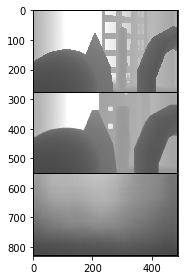

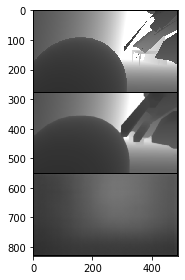

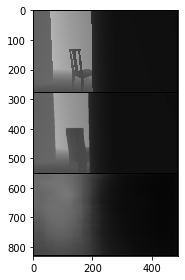

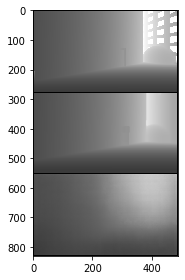

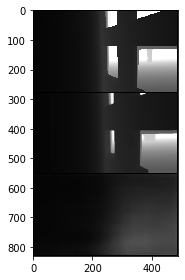

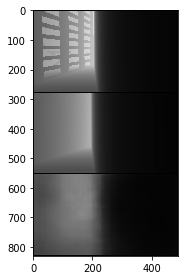

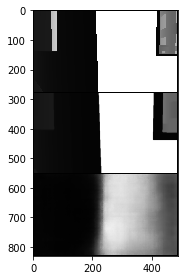

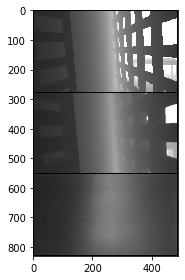

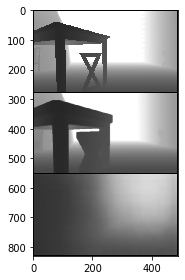

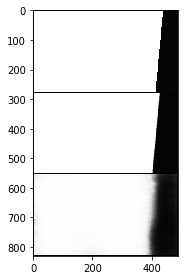

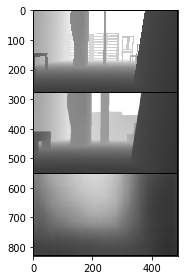

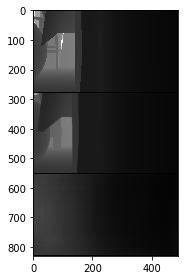

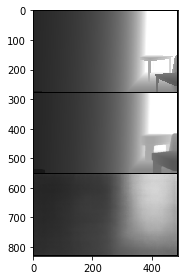

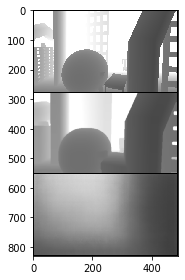

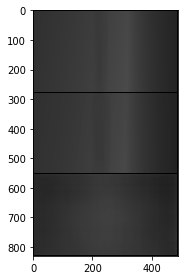

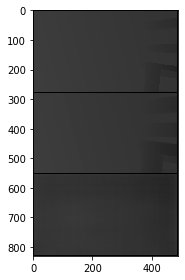

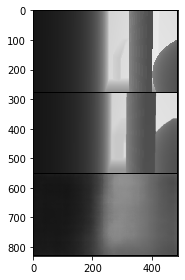

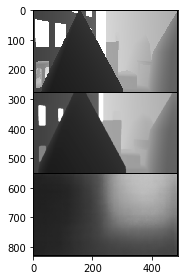

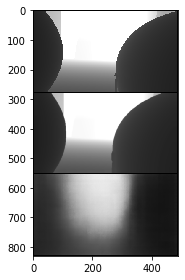

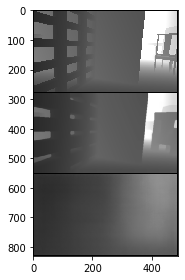

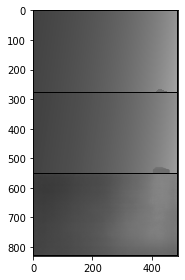

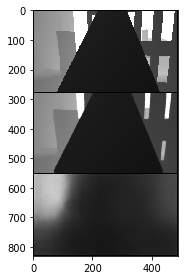

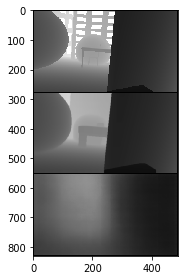

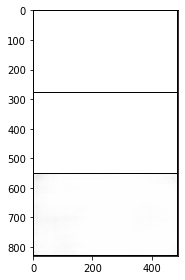

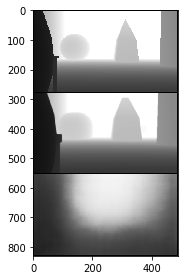

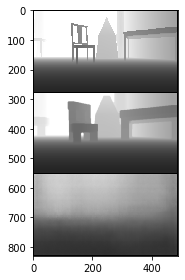

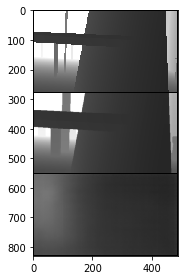

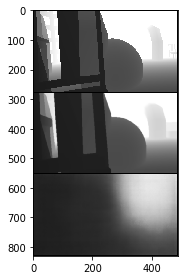

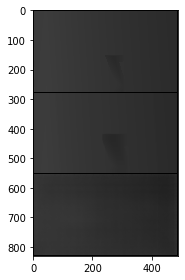

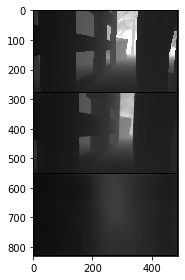

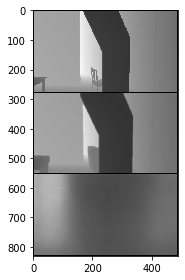

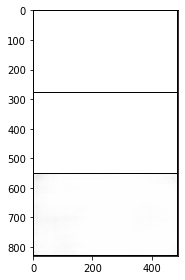

In [14]:
vae_model.eval()

# Visualise sample of images
with torch.no_grad():
    images, filtered, *_ = next(iter(test_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)

In [ ]:
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size, one_tfrecord=True) # load new tfrecord each time
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)

vae_model.eval()

with torch.no_grad():
    images, filtered, *_ = next(iter(train_loader))
    x_hat, *_ = vae_model.forward_test(images)

    print(images.mean(), filtered.mean(), x_hat.mean())
    print(images.var(), filtered.var(), x_hat.var())

    gridshow([images, filtered, x_hat], n_grids=batch_size)